In [588]:
from IPython.core.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [563]:

import time
import json
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from matplotlib.pyplot import MultipleLocator


plt.rcParams['font.sans-serif']=['SimHei'] #set for displaying Chinese characters here.
plt.rcParams['axes.unicode_minus']=False  #set for displaying `-
plt.rcParams['savefig.dpi'] = 500 #图片像素
plt.rcParams['figure.dpi'] = 500 #分辨率

promoters = {"许春龙":100014, "程景瑞":100015, "孙学飞":100016, "原凯":100017, "秦毅": 100018, "蒋黄消":104255, "蒙小香":104939, "钟健":105473}
promoters_inv_code = {"100014":106291, "100015":188894, "100016":105746, "100017":103753, "100018":187686, "104255":576555,"104939":841330,"105473":914048}
promoters_inv_code_l = list(promoters_inv_code.values())

day_dict = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}



# Part1: 购买用户特征分析

## 购买用户分组与统计术语定义：

- 购买 1 组 first_class_user 在平台上购买了一次
- 购买 2 组 second_class_user 在平台上购买了两次 
- 购买 3 组 third_class_user 在平台上购买了三次 
- 购买 4 组 forth_class_user 在平台上购买了四次及以上组 

- 复购用户：下单超过一次的用户，即购买 2，3，4 组。
- 未复购用户：下单仅一次的用户，即购买 1 组。

## 特征分析主要包括以下：
### 1. 复购原因/来源分析

- 不同注册渠道对复购的影响，送口罩活动与不送口罩注册人群的复购分析（比例，客单价）
- 不同日期（星期几）对复购的影响


### 2. 四组购买用户不同维度的分布情况

- 每组**客单均价**的差别、分布是什么（直方图）
- 每组用户**注册日期**（星期几）/时间分布（直方图）
- 每组**最近订单时间**（日期）/直方图

In [411]:
df = pd.read_csv("/Users/lichenxi/work/stat/stat/user_stat/loyal_user_2020-03-24.csv", index_col =0)

In [413]:
user_classify = []
weekday_l = []
newest_order_time_l = []

for index in range(len(df)):
    buy_count = df["buy_count"][index]
    newest_order_time = df["newest_order_time"][index]
    
    if buy_count == 1:
        user_classify.append(1)
    elif buy_count == 2:
        user_classify.append(2)
    elif buy_count == 3:
        user_classify.append(3)
    else:
        user_classify.append(4)
        
    create_time = df["user_account_create_time"][index]
    day = datetime.strptime("%s"%time.strftime('%Y%m%d', time.localtime(create_time)), "%Y%m%d").weekday()
    weekday_l.append(day)
    newest_order_time_l.append(time.strftime('%Y-%m-%d', time.localtime(newest_order_time)))
    
df["newest_order_time_date"] = newest_order_time_l
df["user_classify"] = user_classify
df["weekday"] = weekday_l

### 用户表： 主要包括购买次数，用户分组，客单价，创建时间等

In [481]:
df.head(5)

,user_id,buy_count,sum_user_pay,user_sex,user_account_create_time,profile,reg_invite_code,unit_price,user_ip,source_mask,newest_order_time,source,newest_order_time_date,user_classify,weekday
0,103318,1,37.00,0,1582627628,0,NaN,37.00,14.222.180.96,True,1582628536,直接APP,2020-02-25,1,1
1,105232,1,20.00,0,1584173176,0,841330,20.00,223.104.63.224,True,1584173813,地推,2020-03-14,1,5
2,100202,1,15.64,0,1578887119,0,187686,15.64,223.104.64.24,False,1578887547,地推,2020-01-13,1,0
3,105551,1,27.30,0,1584501555,0,841330,27.30,14.221.98.239,True,1584502489,地推,2020-03-18,1,2
4,105614,1,12.00,0,1584583641,0,841330,12.00,112.97.244.106,True,1584583905,地推,2020-03-19,1,3


In [482]:
source_dict = {}
for source in df["source"].unique():
    source_dict[source] = "{:.2%}".format(round(len(df[df["source"] == source]) / len(df),4))
print("所有下单用户的来源分布: ")    
source_dict


所有下单用户的来源分布: 


{'直接APP': '6.54%', '地推': '73.36%', '活动': '17.96%', '现场支付': '2.13%'}

In [486]:
mask_rate = round(len(df[df["source_mask"] == True]) / len(df),4)
print("所有用户中参与了送口罩活动中达到了 {:.2%}".format(mask_rate))



所有用户参与了送口罩活动中达到了 90.36%


In [487]:
opt_df = df[df["buy_count"] != 1]
mask_rate = round(len(opt_df[opt_df["source_mask"] == True]) / len(opt_df),4)
print("复购用户中参与了送口罩活动的达到了 {:.2%}".format(mask_rate))

# 还需要把剩下的百分之 6 拉出来看一下


复购用户中参与了送口罩活动的达到了 94.04%


In [417]:
weekday_dict = {}
for day in df["weekday"].unique():
    weekday_dict[day] = "{:.2%}".format(round(len(df[df["weekday"] == day]) / len(df),4))
    
print("所有下单用户的注册日期分布（按星期几）")
[(day_dict[k],weekday_dict[k]) for k in sorted(weekday_dict.keys())] 

所有下单用户的注册日期分布（按星期几）


[('Mon', '12.74%'),
 ('Tue', '9.06%'),
 ('Wed', '11.69%'),
 ('Thu', '15.10%'),
 ('Fri', '13.12%'),
 ('Sat', '17.31%'),
 ('Sun', '20.98%')]

In [427]:
unit_price_dict = {}
df_user_sorted = df["user_classify"].unique()
df_user_sorted.sort()
for classify in df_user_sorted:
    dfs = df[df["user_classify"] == classify]
    print("购买 %s 组的用户共有：%s 位，消费总额：%s，平均客单价：%s"%
          (classify,
           len(dfs),
           round(sum(dfs["unit_price"]),2),
           round(sum(dfs["unit_price"])/len(dfs),2)
          ))

购买 1 组的用户共有：2080 位，消费总额：41622.64，平均客单价：20.01
购买 2 组的用户共有：297 位，消费总额：11819.69，平均客单价：39.8
购买 3 组的用户共有：97 位，消费总额：5270.06，平均客单价：54.33
购买 4 组的用户共有：109 位，消费总额：5362.4，平均客单价：49.2


In [448]:
user_classify_1 = np.array(list(df[df["user_classify"] == 1]["unit_price"])) 
user_classify_2 = np.array(list(df[df["user_classify"] == 2]["unit_price"])) 
user_classify_3 = np.array(list(df[df["user_classify"] == 3]["unit_price"])) 
user_classify_4 = np.array(list(df[df["user_classify"] == 4]["unit_price"])) 

### 购买 1 组的用户客单价直方图

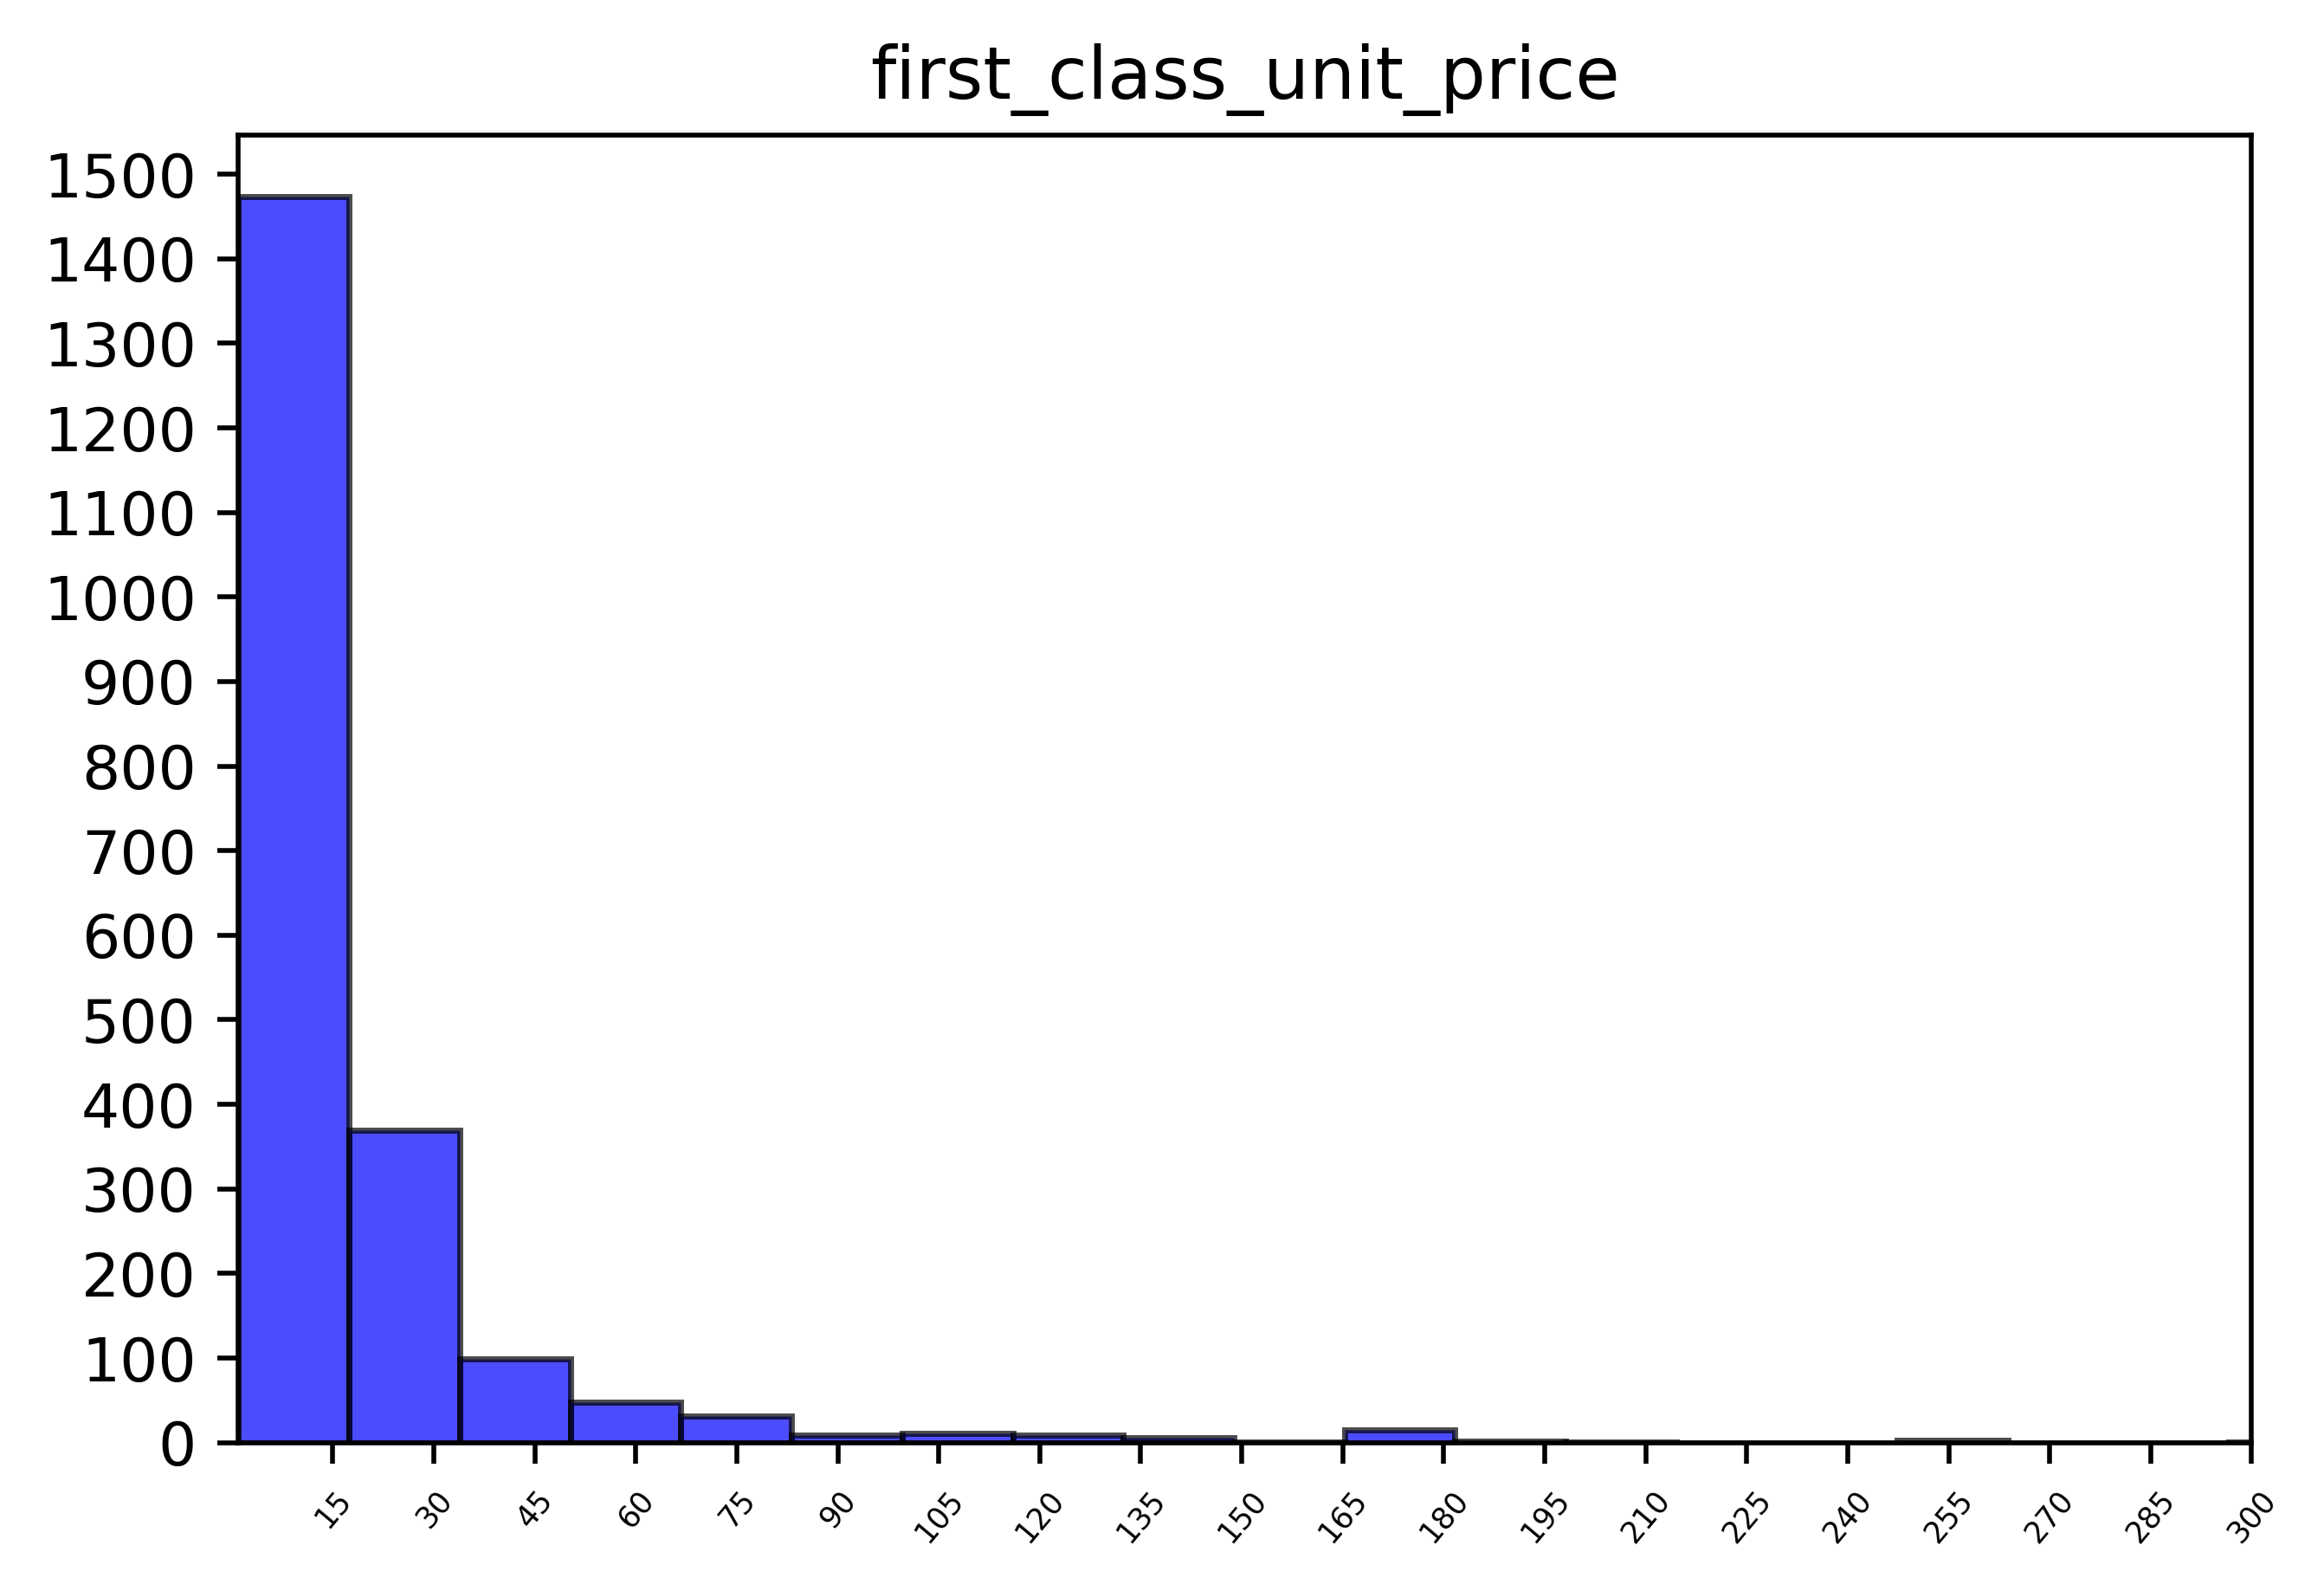

In [489]:
plt.hist(user_classify_1, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("first_class_unit_price")
plt.xlim(1,300)

x_major_locator = MultipleLocator(15)
y_major_locator=MultipleLocator(100)
plt.gca().yaxis.set_major_locator(y_major_locator)
plt.gca().xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=50)
plt.xticks(fontsize=5)
plt.show()

### 购买 2 组的用户客单价直方图

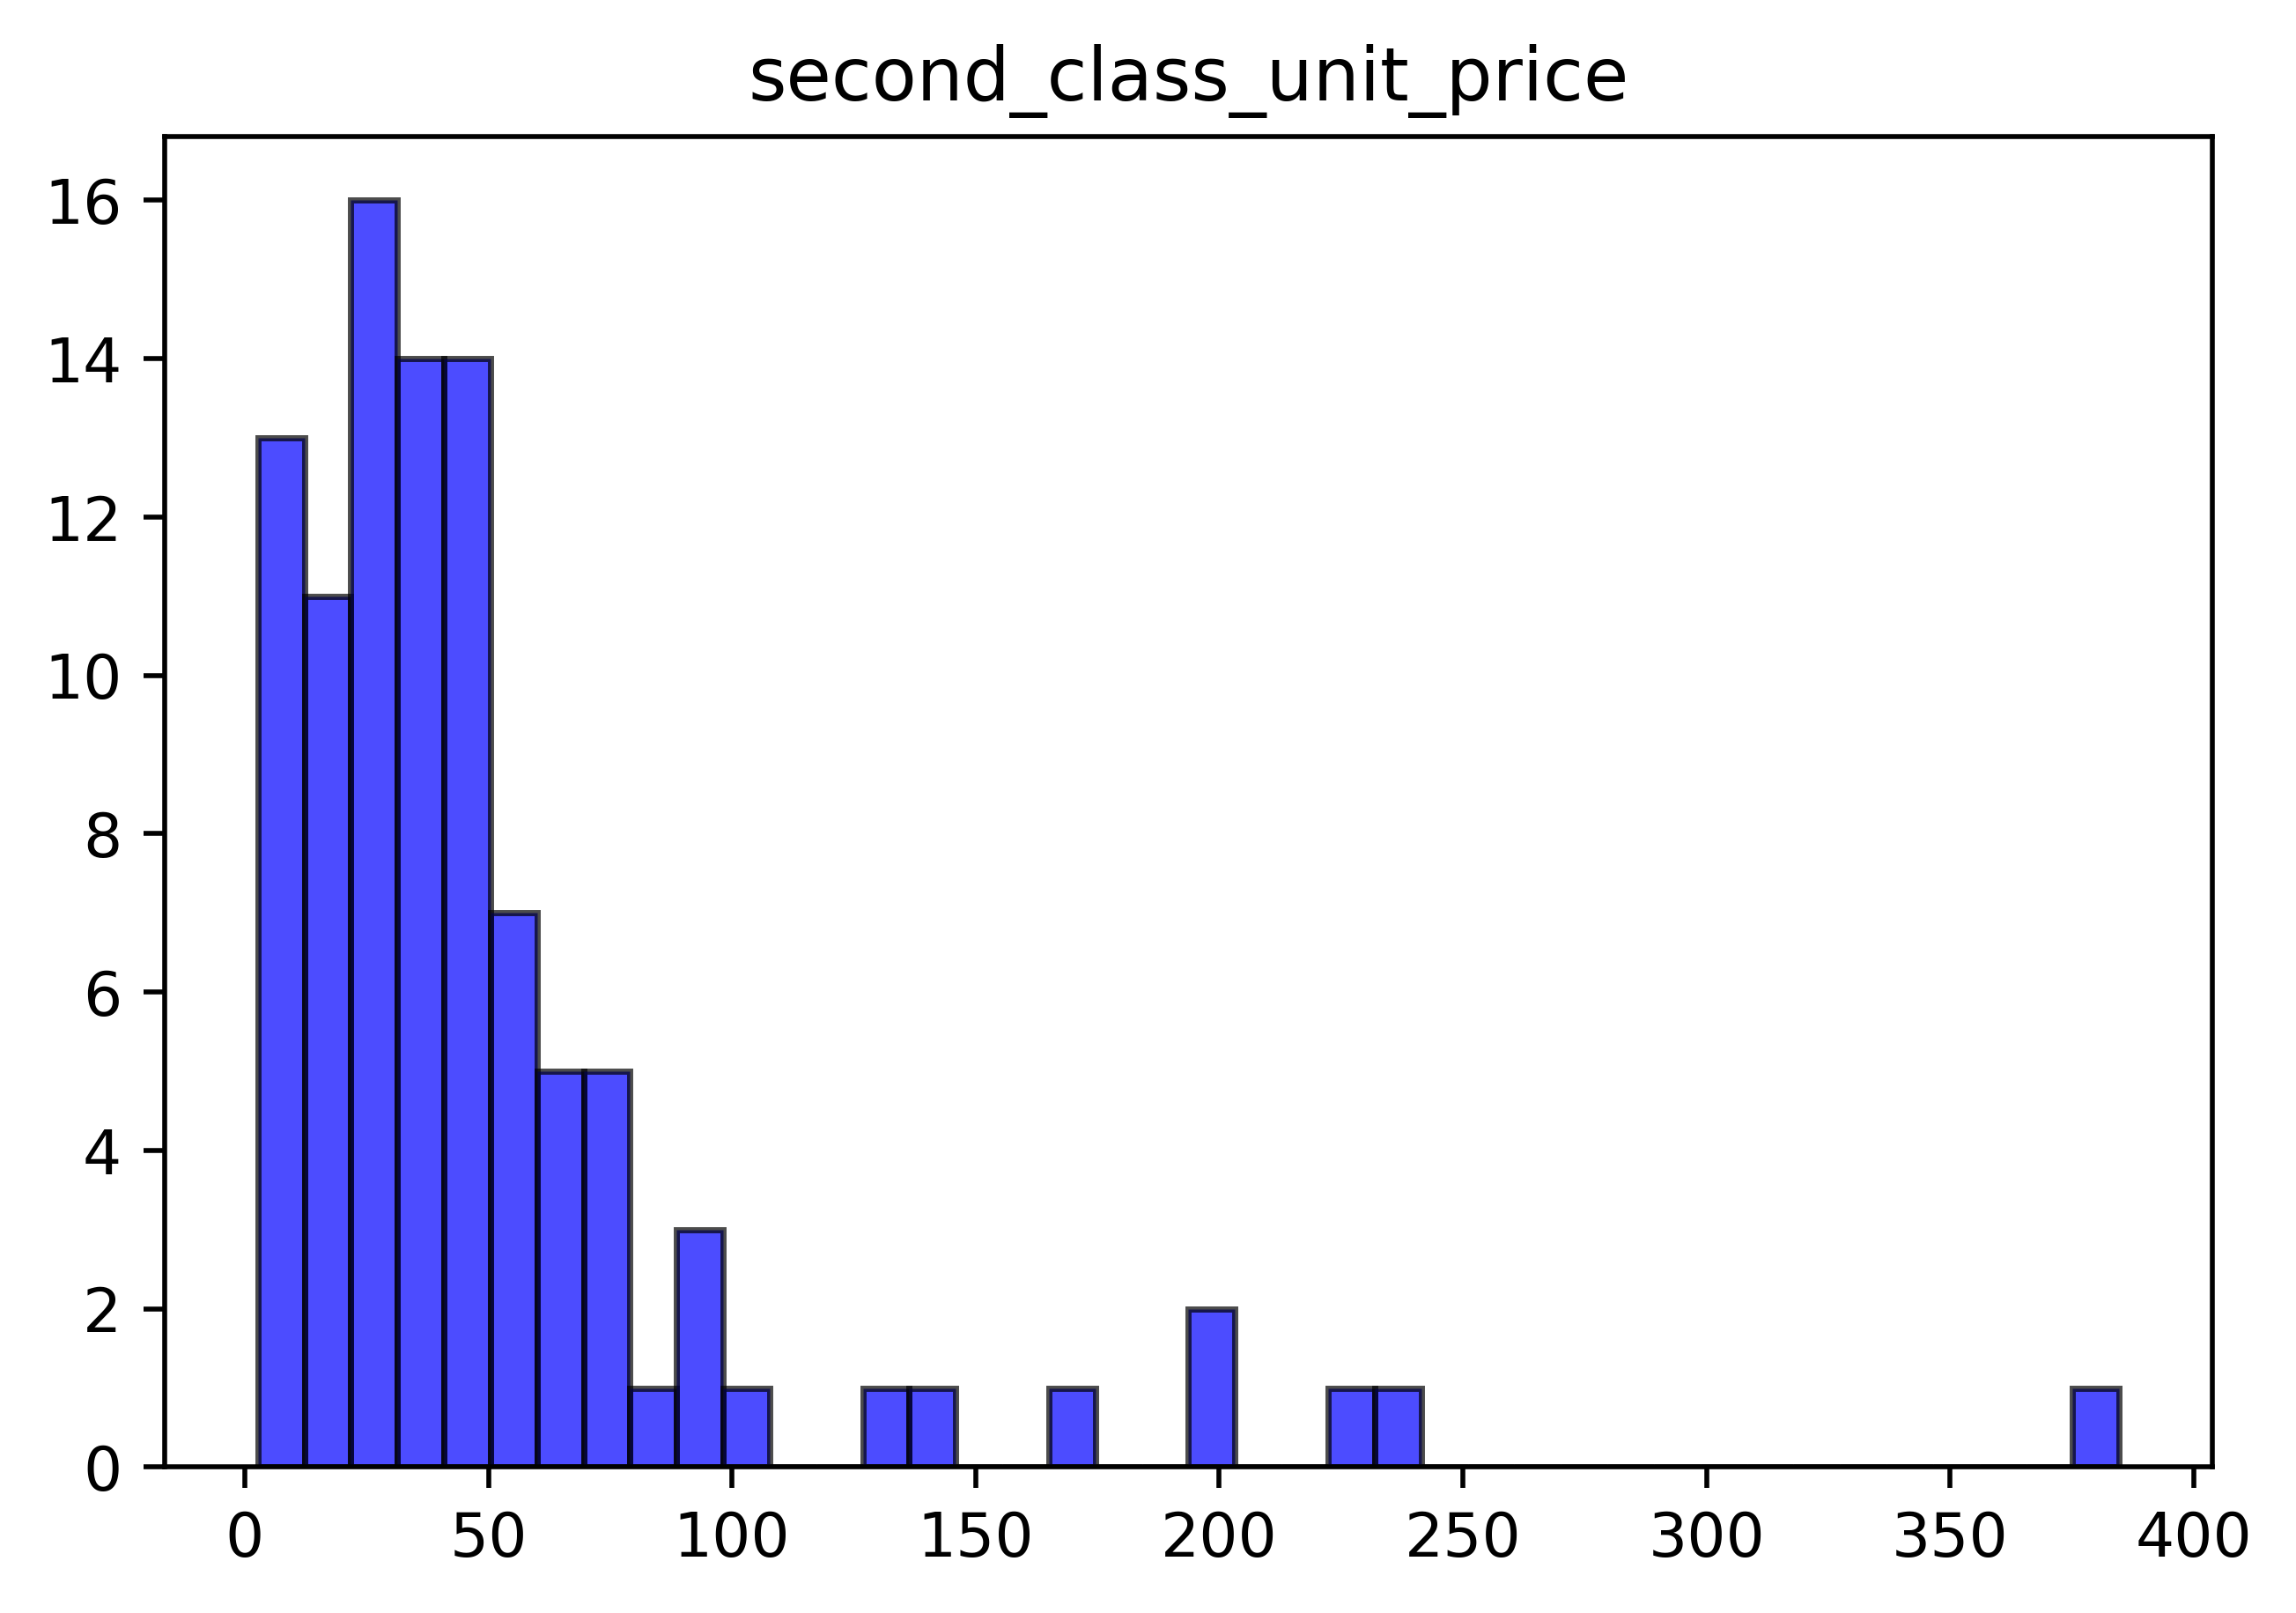

In [352]:
plt.hist(user_classify_2, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("second_class_unit_price")
plt.show()


### 购买 3 组的用户客单价直方图

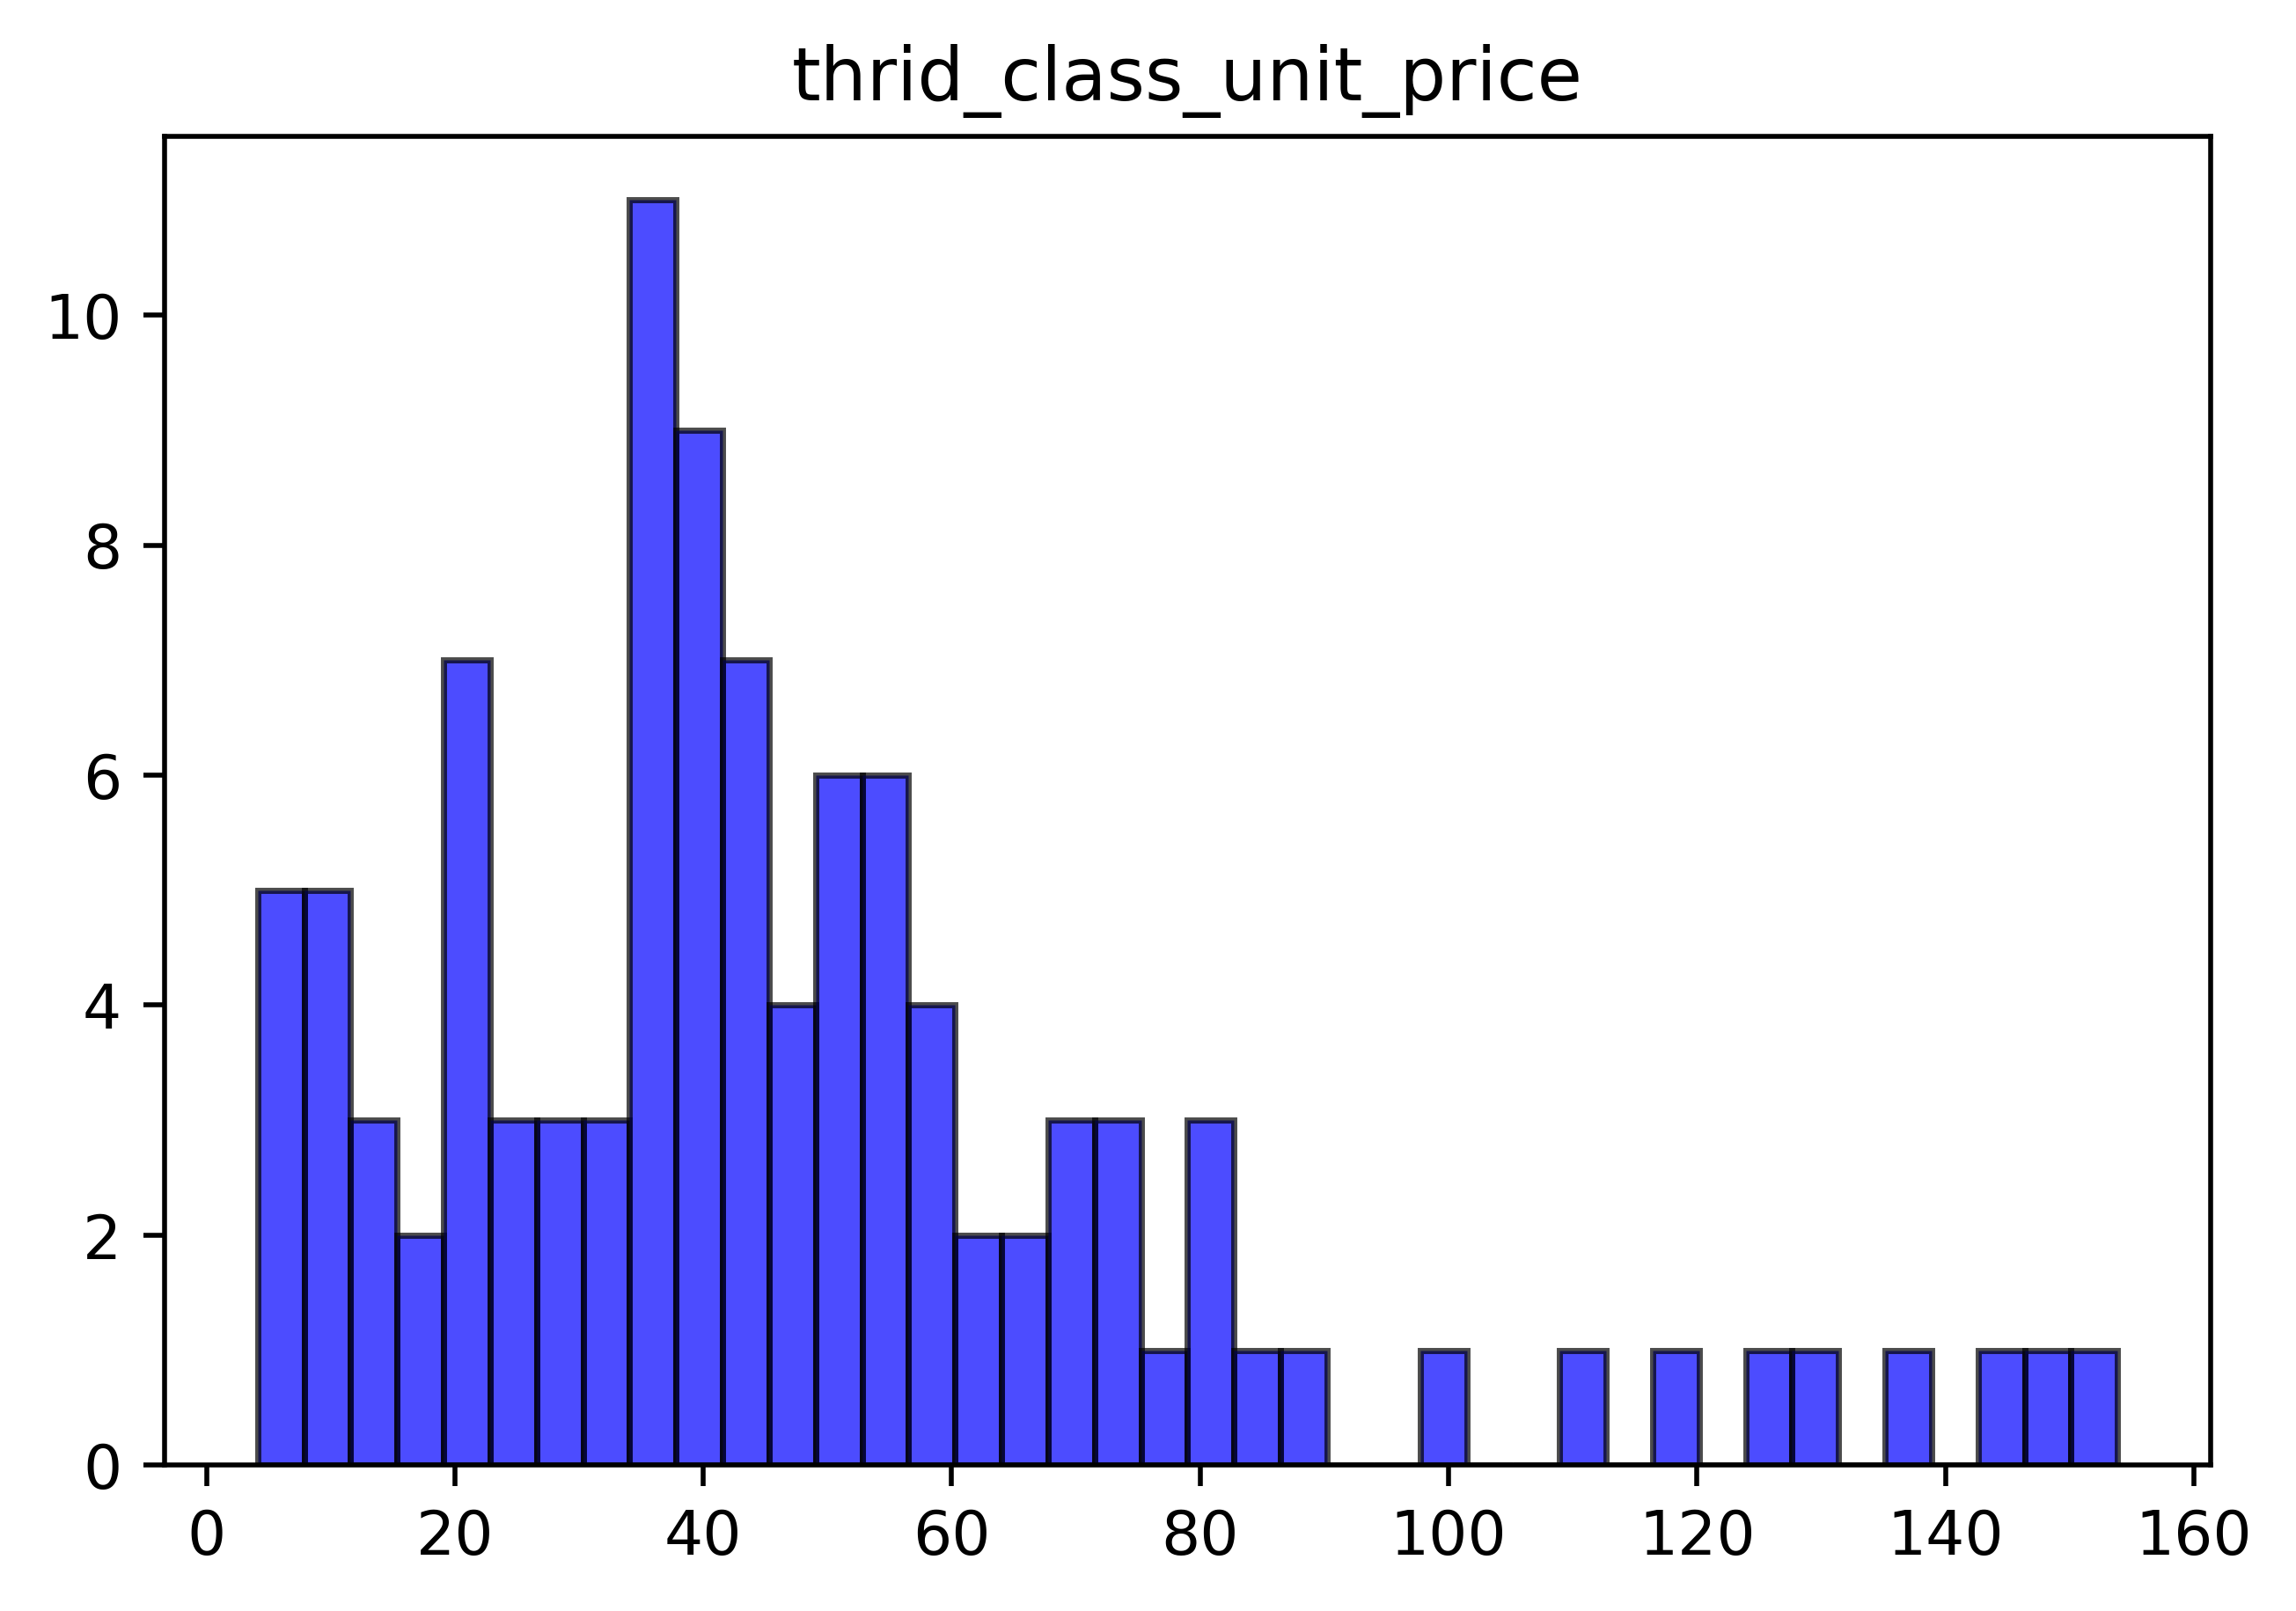

In [349]:
plt.hist(user_classify_3, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("thrid_class_unit_price")
plt.show()

## 用户 104260 下了三单 其中一单最高 864 元，所以出现了一个 388 的客单价

### 购买 4 组的用户客单价直方图

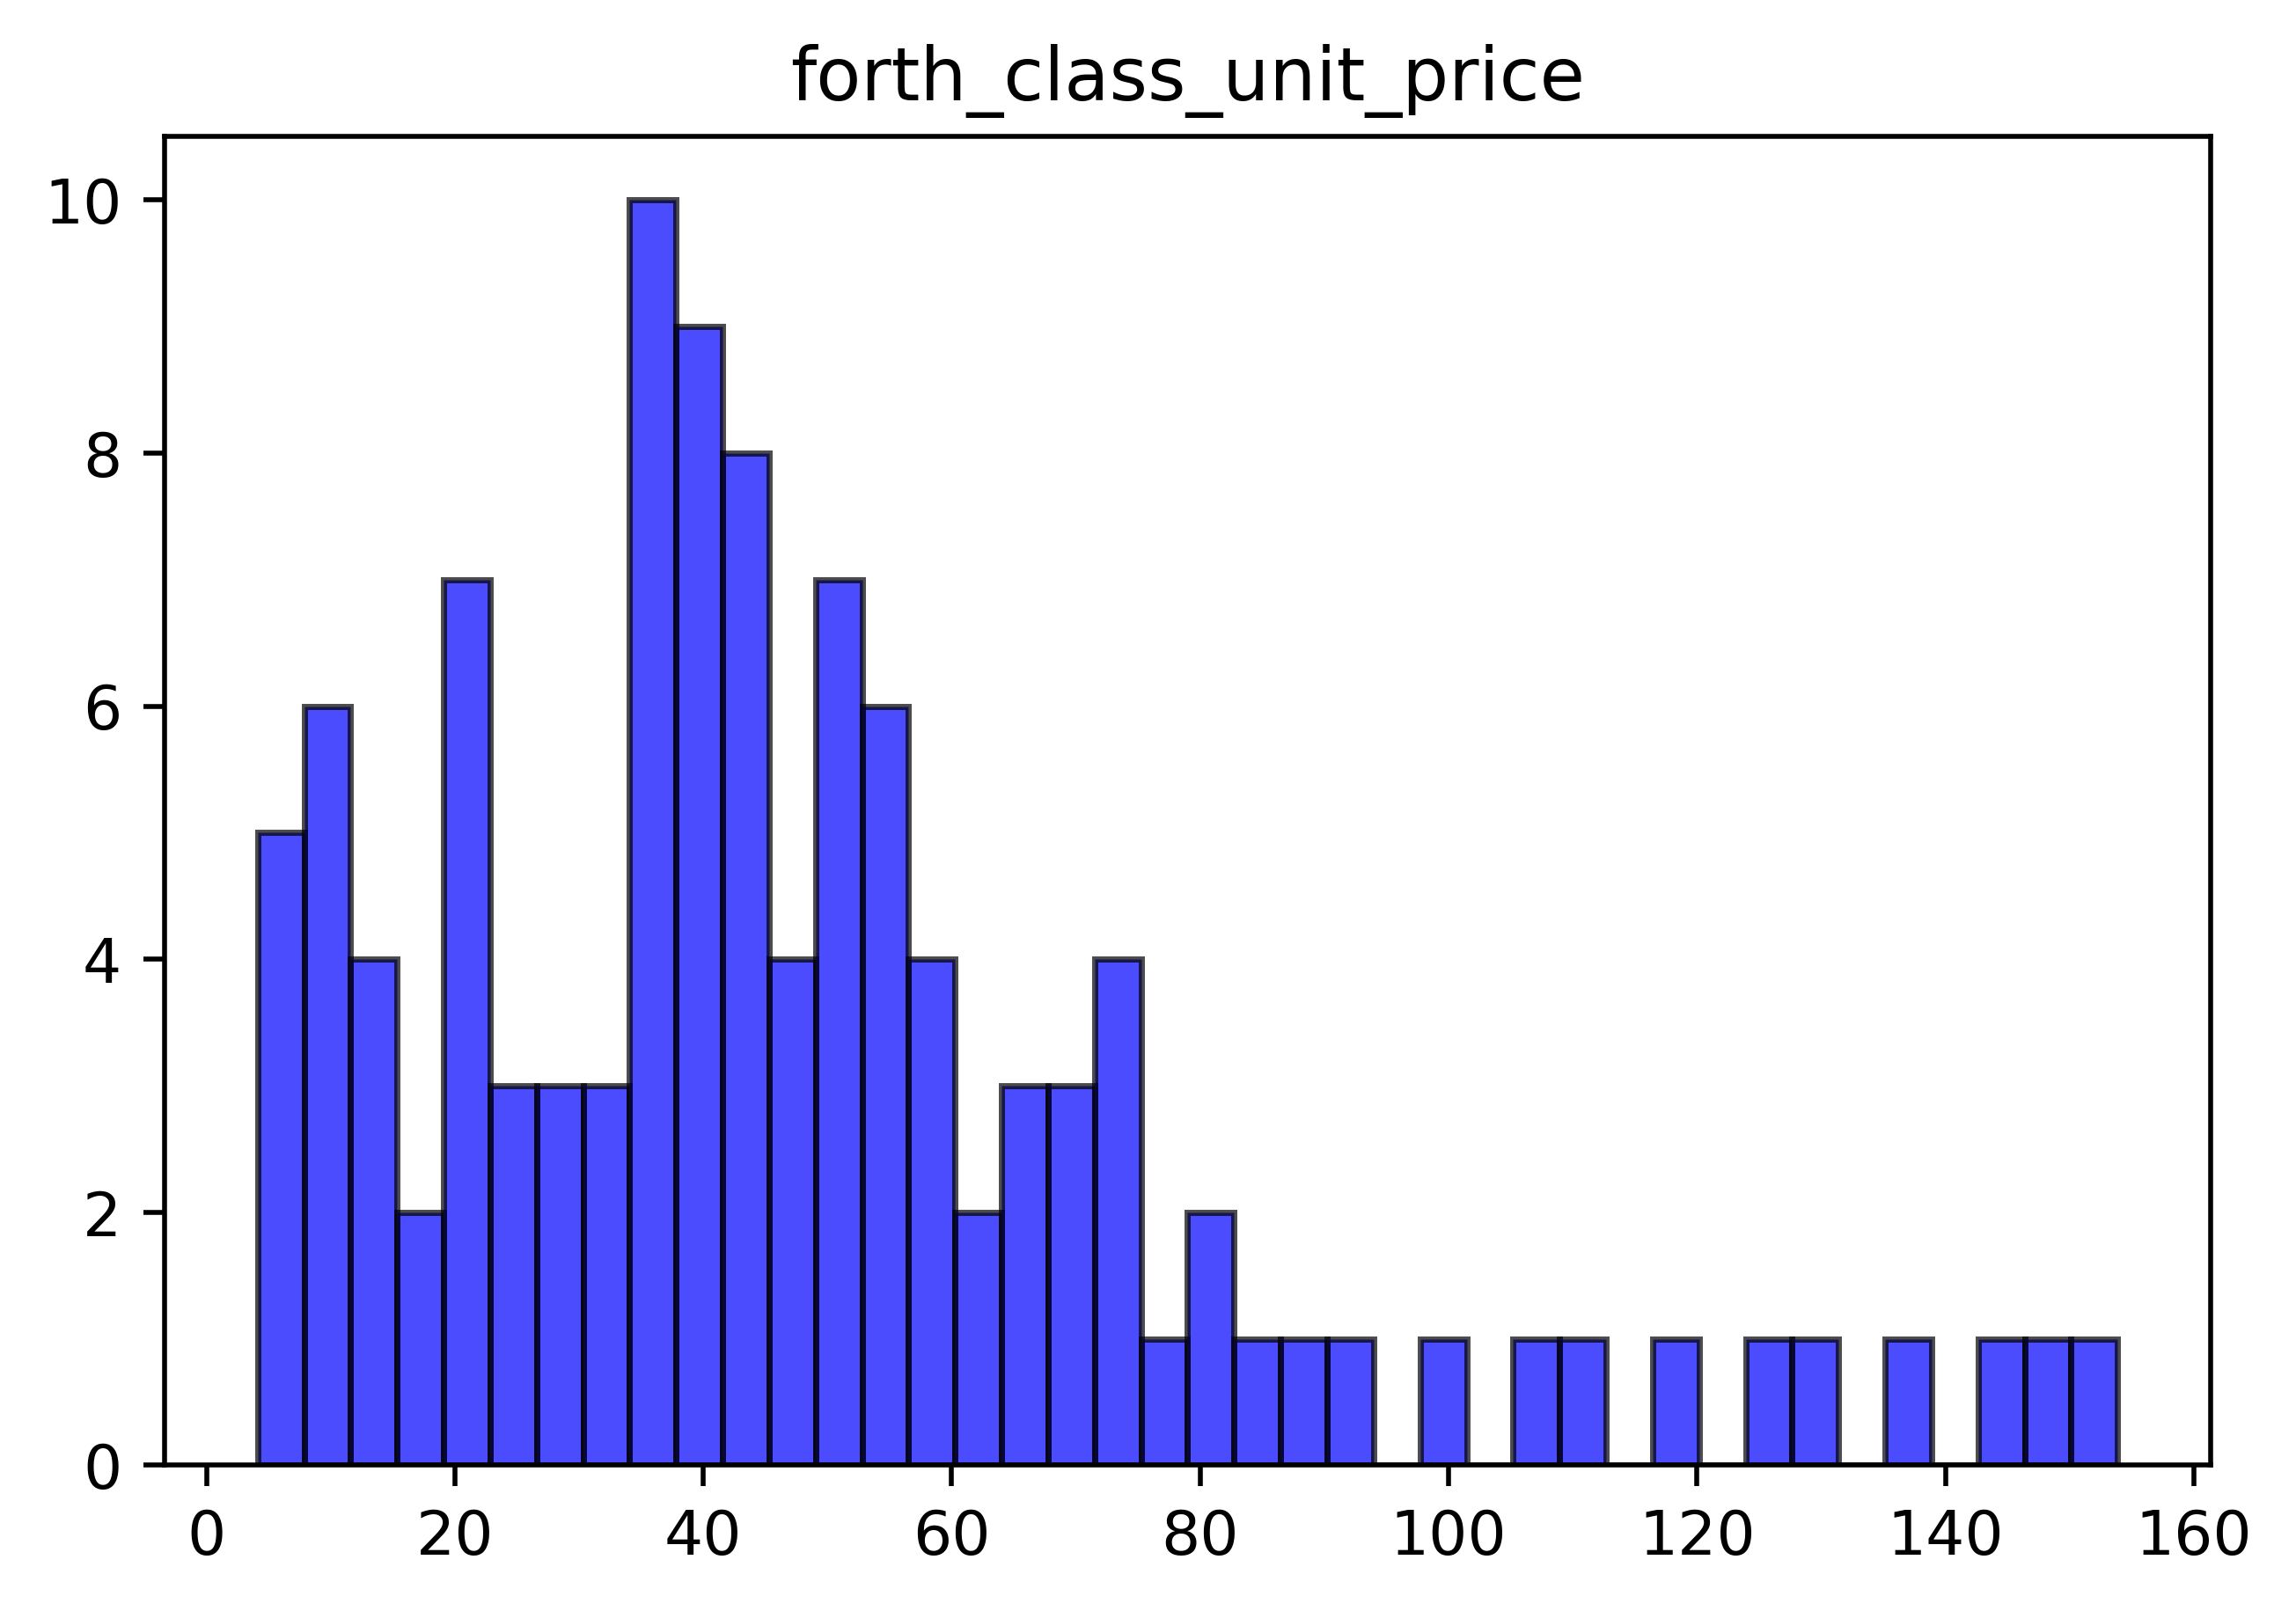

In [490]:
plt.hist(user_classify_4, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("forth_class_unit_price")
plt.show()


## 从四个组别的用户客单价直方图可以得出以下结论：

- 1. 购买 1 次的用户平均客单价虽然是 20 元，但是大部分都分布在 15 元以内 
- 2. 购买 2 次的用户平均客单价是购买 2 次的一倍，主要分布在 10 - 50 元的区间
- 3. 购买三次的用户和购买多次的用户数量相当，平均客单价相当
- 4. 购买多次的用户在客单价上分布的较为分散，在 20 - 60 的客单价区间相对集中。


In [409]:
# # 日期（周几）分布直方图
# user_create_time_1 = np.array(list(df[df["user_classify"] == 1]["weekday"])) 
# user_create_time_2 = np.array(list(df[df["user_classify"] == 2]["weekday"])) 
# user_create_time_3 = np.array(list(df[df["user_classify"] == 3]["weekday"])) 

# plt.hist(user_create_time_1, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.title("first_class_weekday")
# plt.show()

# plt.hist(user_create_time_2, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.title("second_class_weekday")
# plt.show()

# plt.hist(user_create_time_3, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.title("thrid_class_weekday")
# plt.show()

In [467]:
def generate_order_time_list(classify):
    opt_df = df[df["user_classify"] == classify]
    opt_df.sort_values("newest_order_time_date",inplace = True)
    
    rate = len(opt_df)/len(opt_df["newest_order_time_date"].unique())
    return np.array(list(opt_df["newest_order_time_date"])),rate


### 购买 2 组的用户最近下单日期（天）直方图

/Users/lichenxi/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


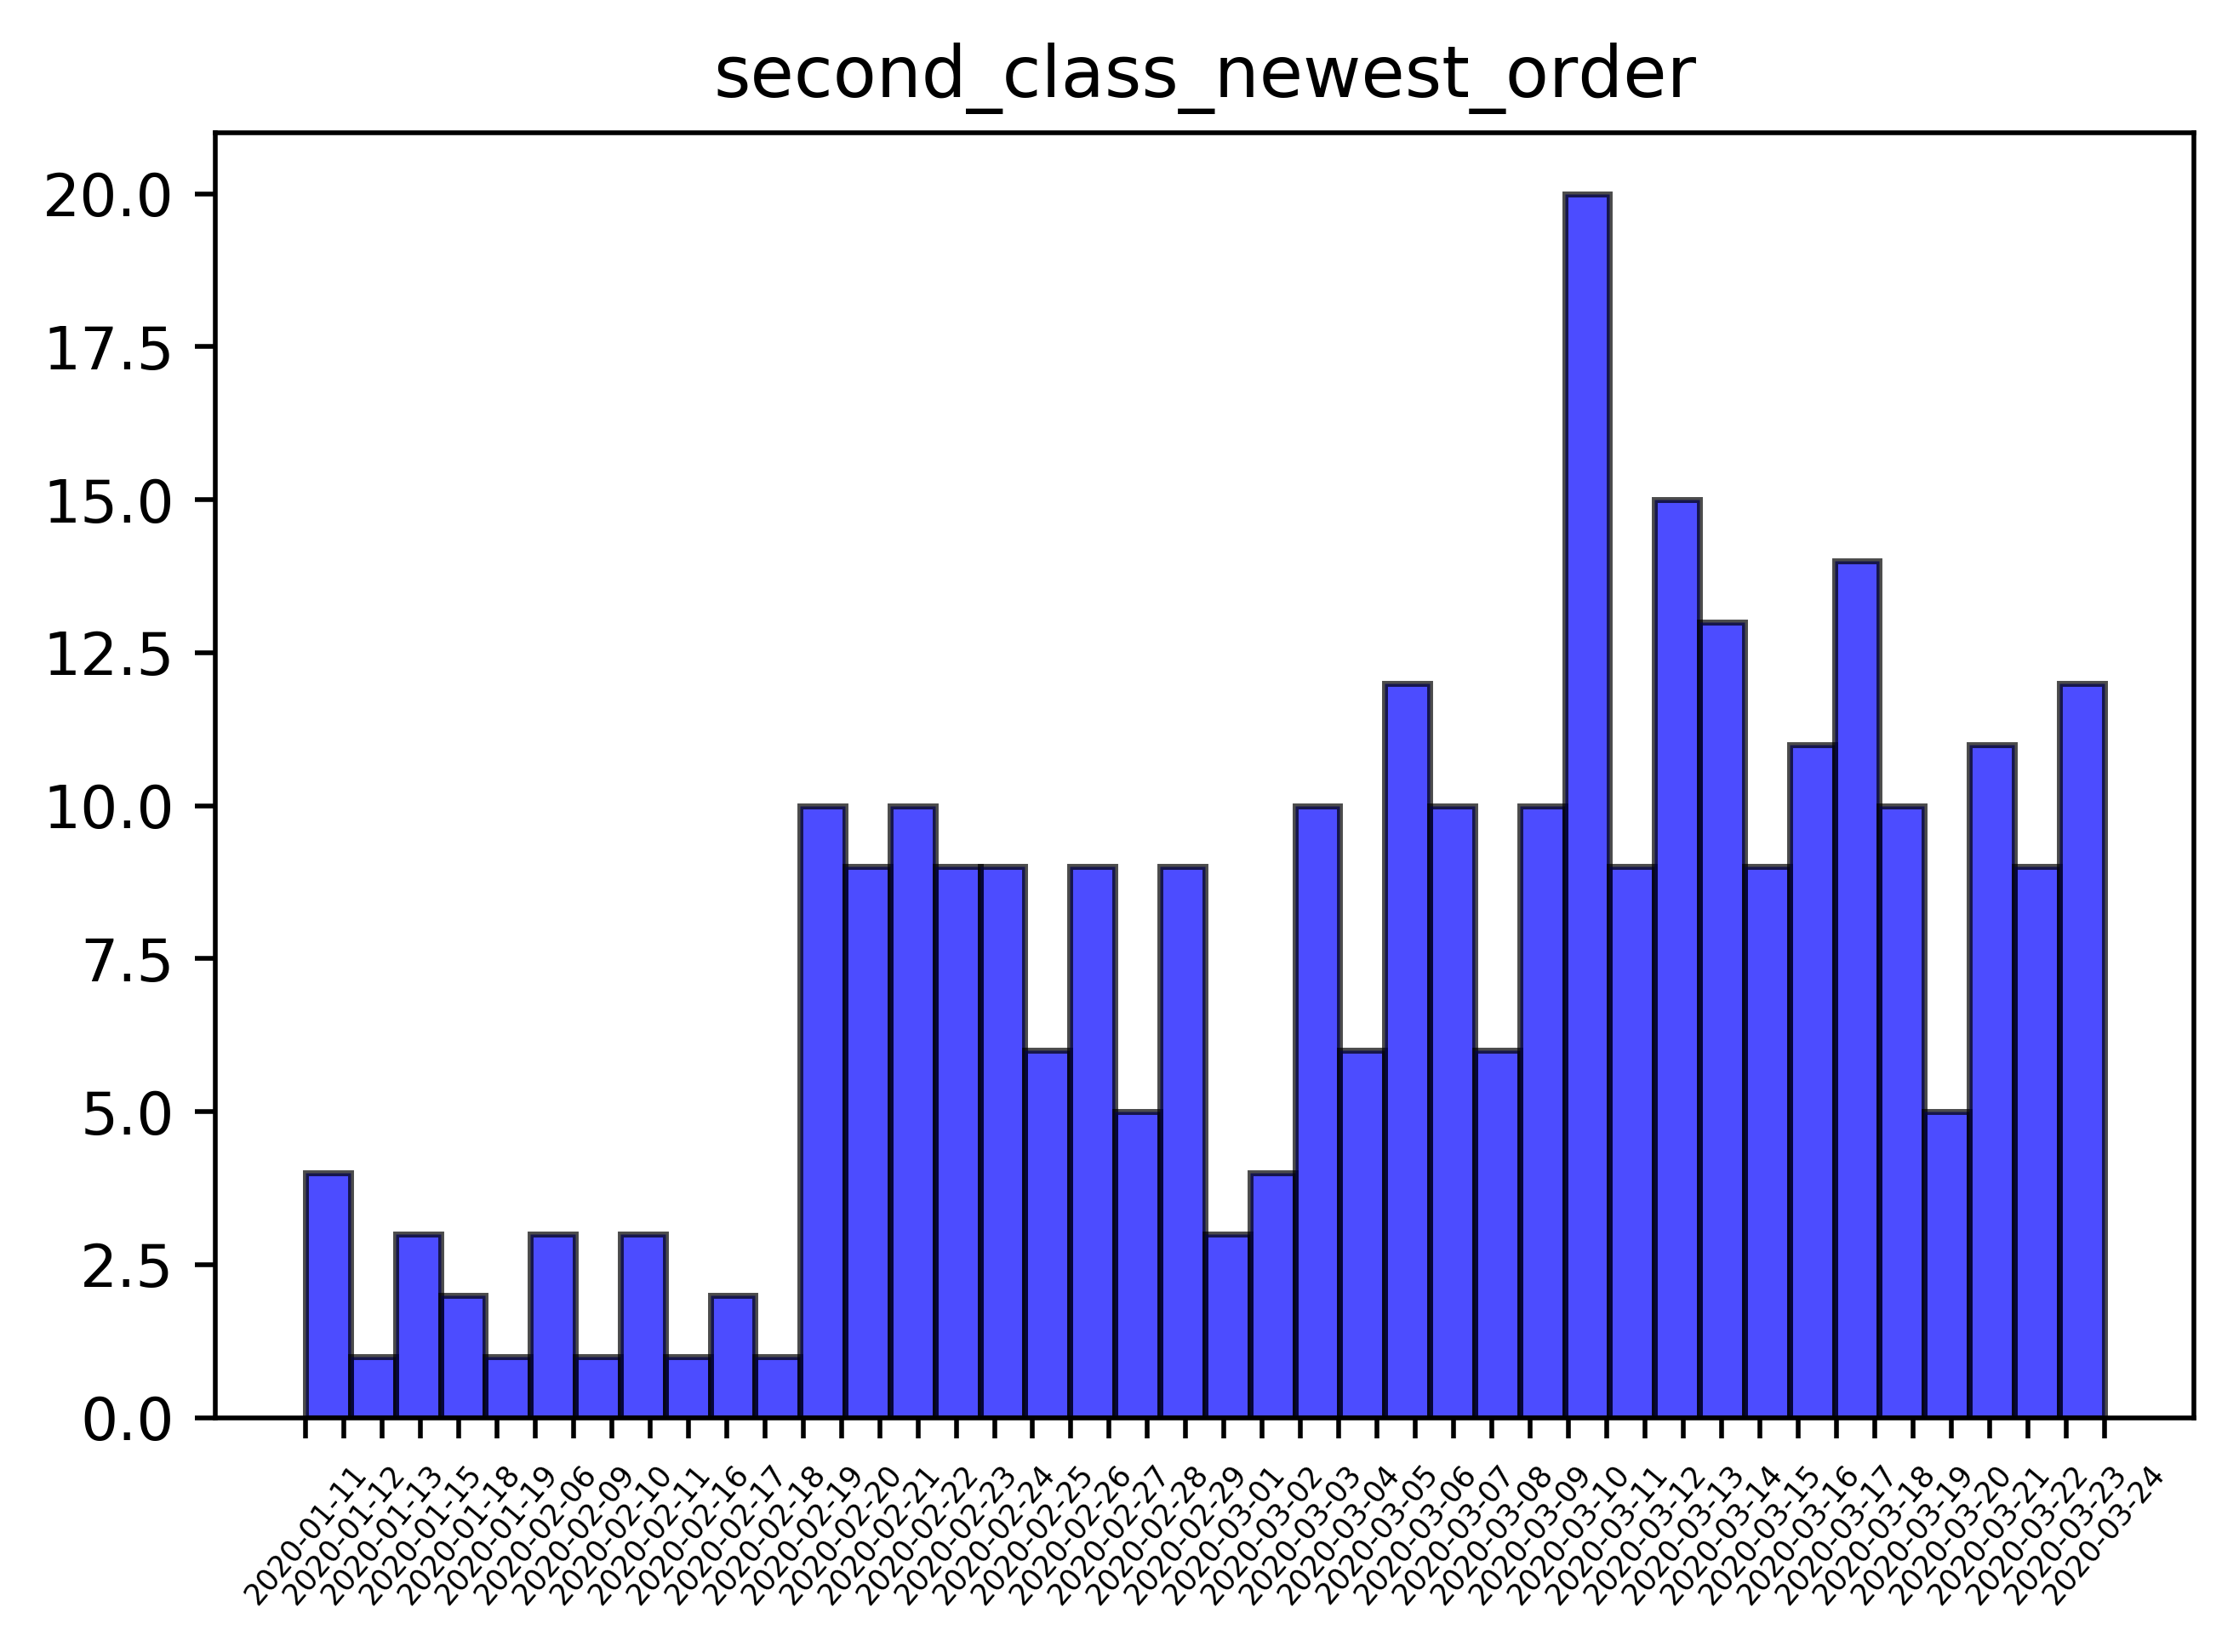

平均每天产生了 6.1875 个购买两次用户


In [470]:

order_time_2, number_of_loyals = generate_order_time_list(2)
plt.hist(order_time_2, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("second_class_newest_order")
plt.xticks(rotation=50)
plt.xticks(fontsize=5)
plt.show()

# 对于这个组的用户，最新订单即是他们在平台上的最后一单。

print("平均每天产生了 %s 个购买 2 组用户"%number_of_loyals)


### 购买 3 组的用户最近下单日期（天）直方图

/Users/lichenxi/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


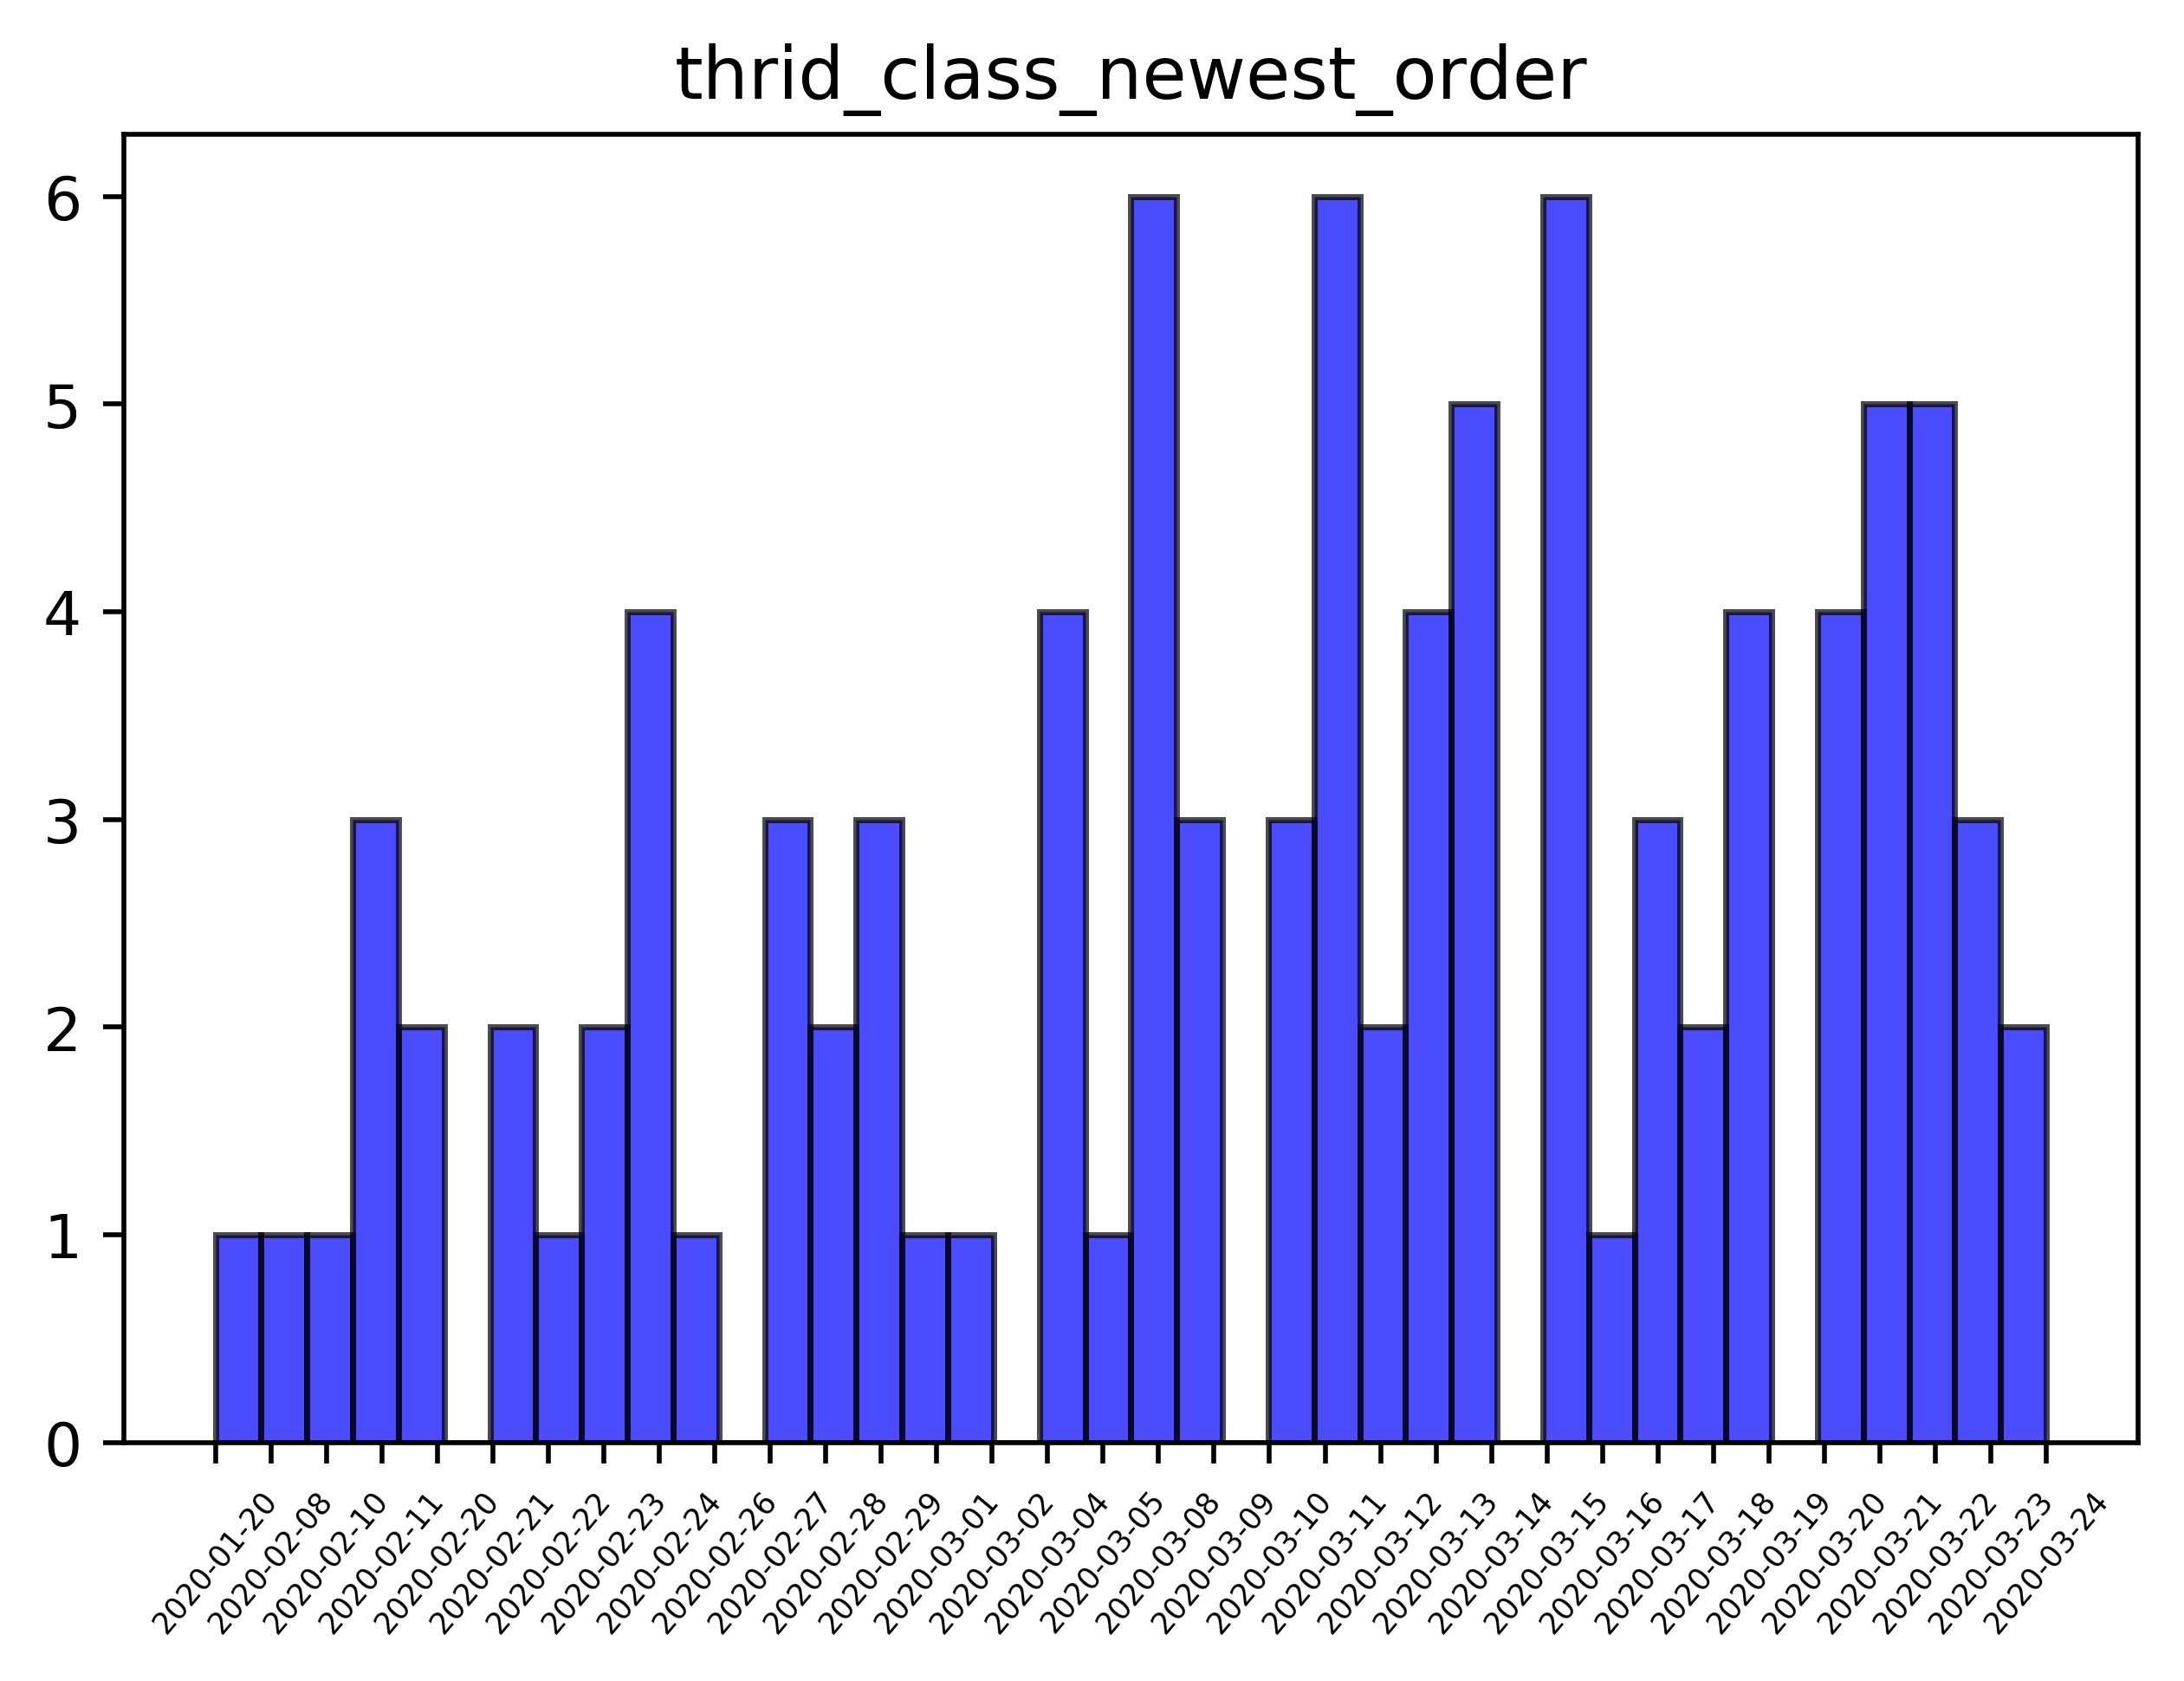

平均每天产生了 2.8529411764705883 个购买三次用户


In [471]:
# 购买三次用户的最近下单时间分布

order_time_3, number_of_loyals = generate_order_time_list(3)
plt.hist(order_time_3, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("thrid_class_newest_order")
plt.xticks(rotation=50)
plt.xticks(fontsize=5)
plt.show()

print("平均每天产生了 %s 个购买 3 组用户"%number_of_loyals)

/Users/lichenxi/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


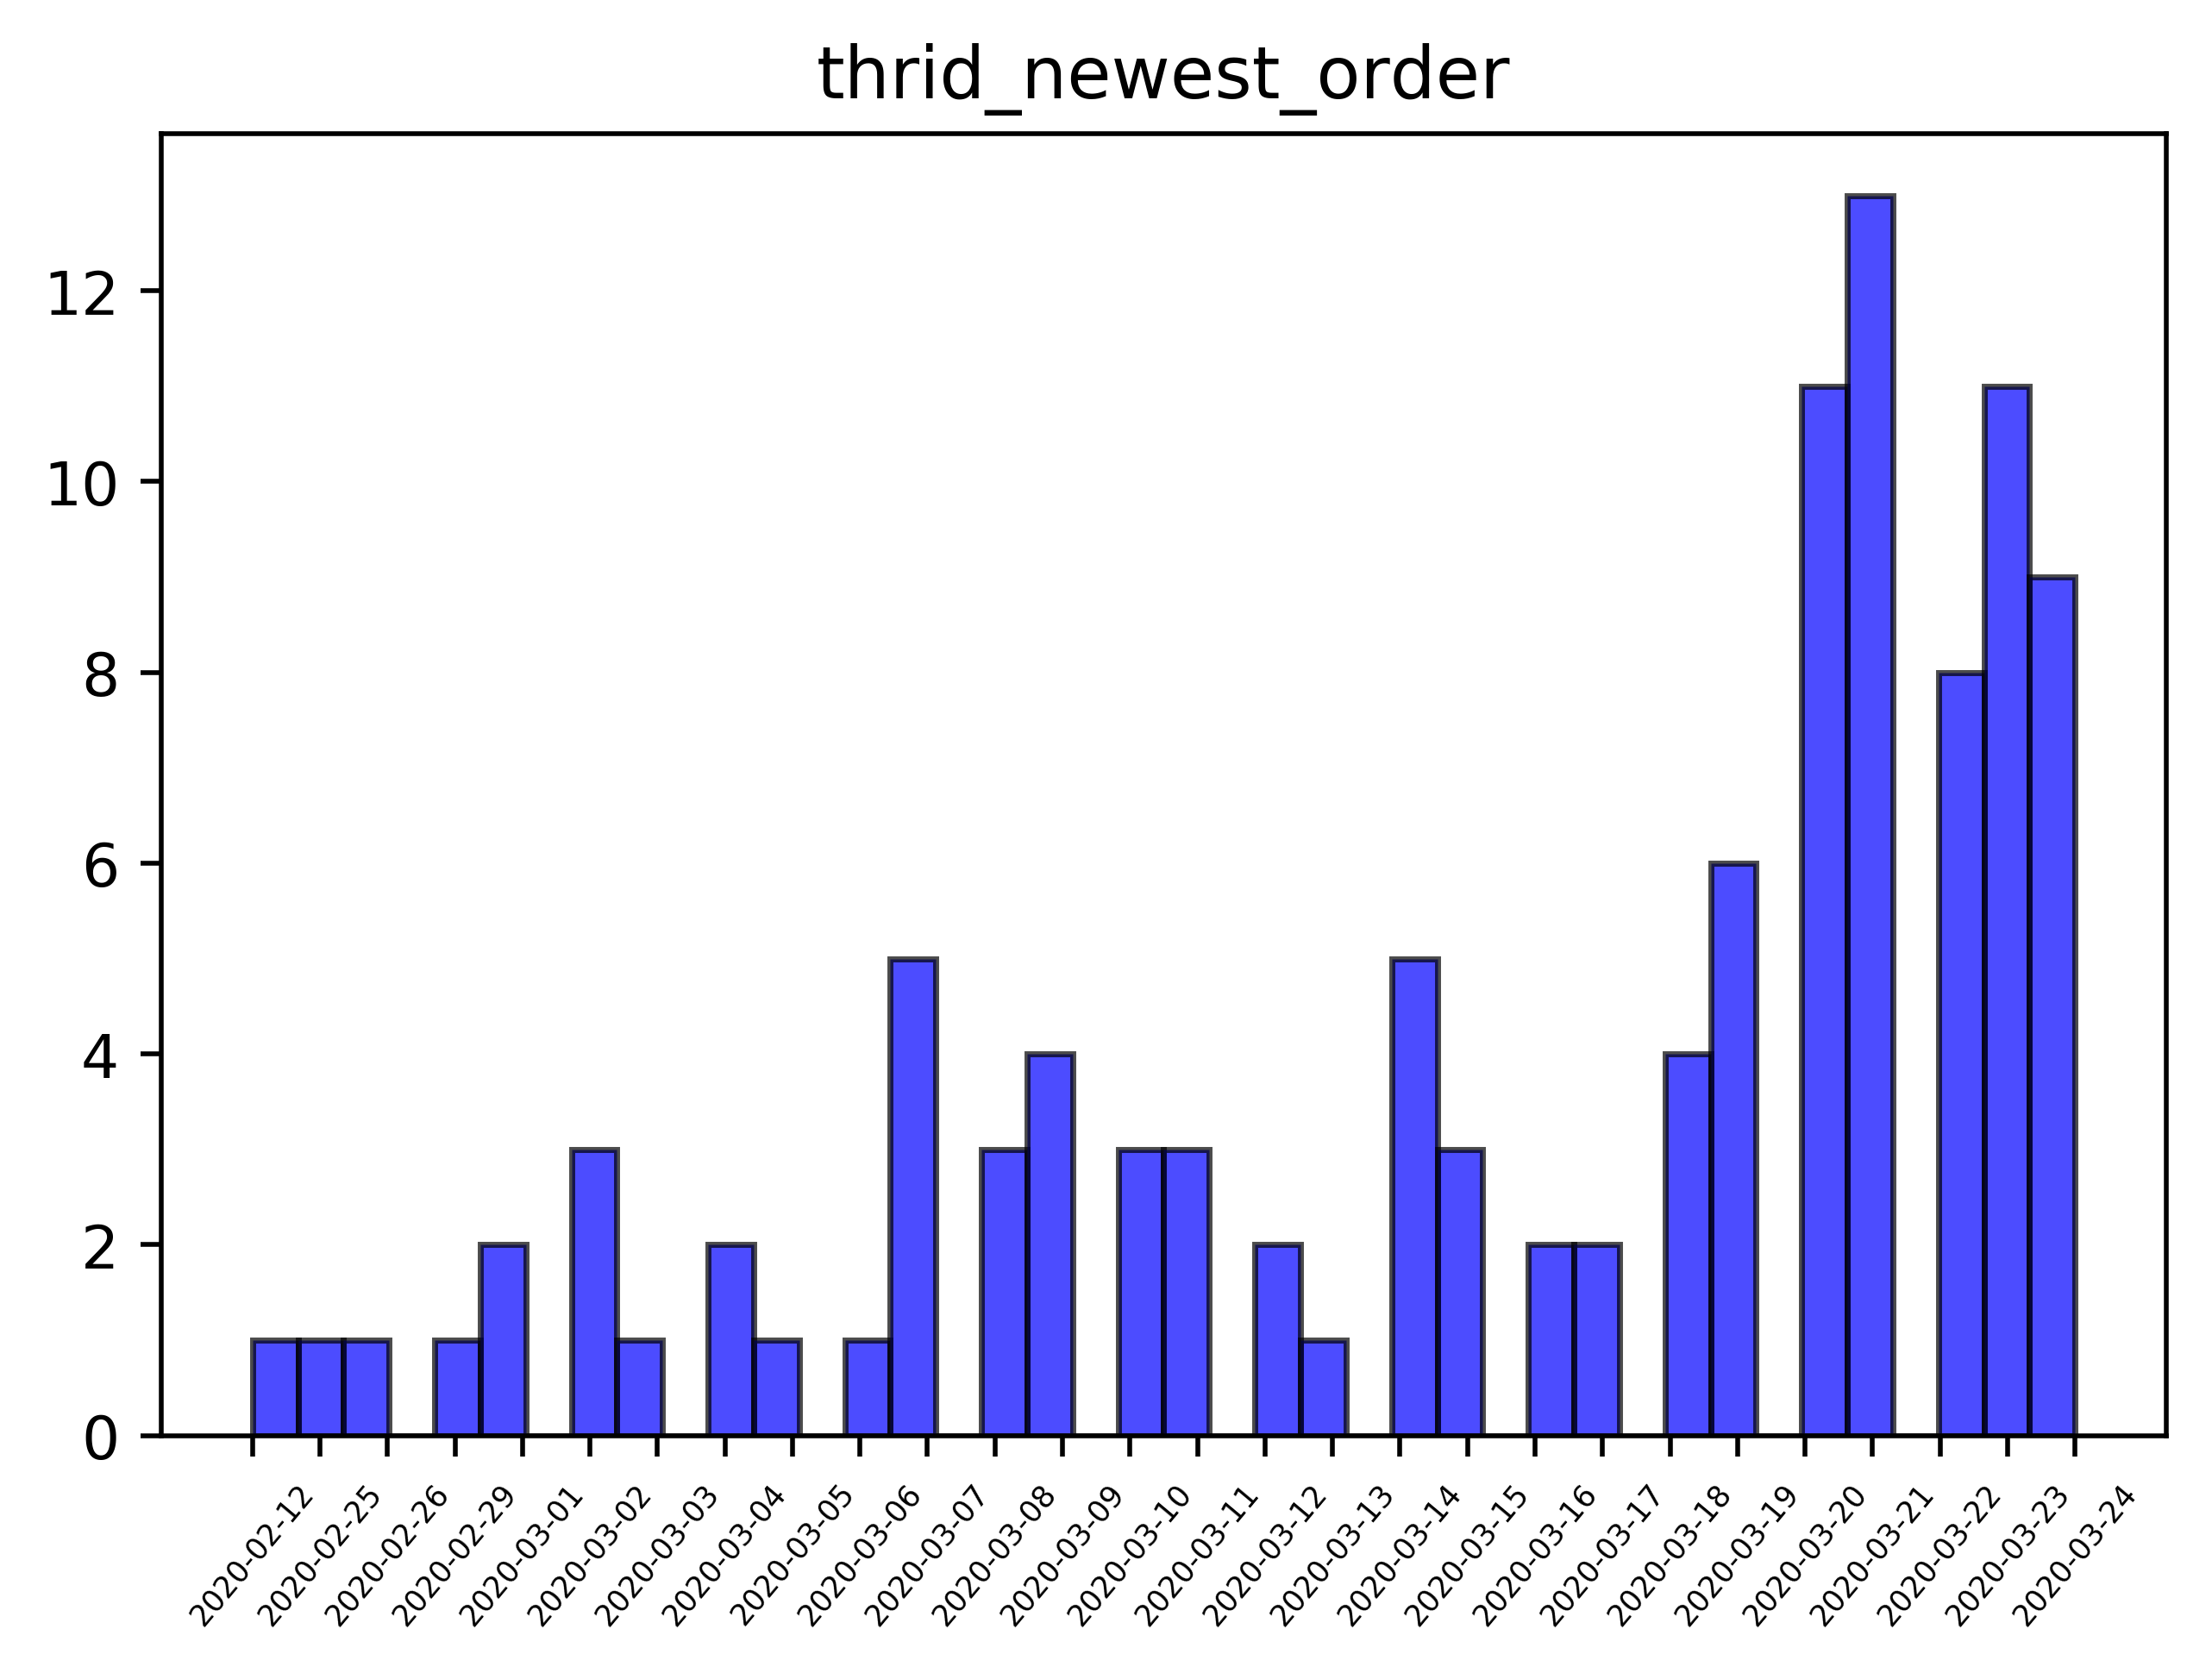

In [472]:
# 购买四次用户的最近下单时间分布
order_time_4, number_of_loyals = generate_order_time_list(4)
plt.hist(order_time_4, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("thrid_newest_order")
plt.xticks(rotation=50)
plt.xticks(fontsize=5)
plt.show()

print("平均每天产生了 %s 个购买 4 组用户"%number_of_loyals)

### 复购用户最近订单分析的结论：

- 1. 复购一次的用户（总单 2）最近订单的总体分布比较平均，这意味着我们每天都有 6-10 个左右的用户在复购。同时可以看出 2 月 18 号之后复购用户明显增多，当天有外部群口罩活动分享的事件。
- 2. 复购两次的用户（总单 3）同样分布平均，每天大约有 3 个复购两次的用户
- 3. 因此可以估算出复购一次到复购二次的用户转化率大致为 37% （3/8，8 是在 6 和 10 之间取了中间值）
- 4. 复购多次（总单大于3）的用户分布大多集中在直方图右侧，说明这批用户粘性较高，最新订单的时间都很接近。且用户的最近复购时间都发生在 2 月 12 号之后，2 月 11 号是送口罩活动的上线的时间。


# Part2: 结合用户订单表来继续分析

- 复购用户的下单时间（时间段）
- 复购用户的商品
- 复购用户第二单的情况
    - 订单优惠与优惠券
    - 是否参加活动


In [492]:
df_order = pd.read_csv("/Users/lichenxi/work/stat/stat/income_stat/daily_order_2020-03-24.csv", index_col =0)

## 订单表概览
- 主要包括：订单号 期望派送时间 下单时间 优惠金额 优惠券名称 订单子商品



In [514]:
df_order.head(3)

,order_id,order_create_time,expect_deliver_time,pay_type,pay_status,user_pay_price,user_discount_price,coupons_name,sub_product,address,order_note,user_id,tel,name,user_create_time,profile,inviter_id,inviter_tel,reg_invite_code,inviter_create_time
0,110001233,2020-01-10 17:14:36,2020-01-10 18:00:00,1,1,12.36,0.0,NaN,"['一点红番薯', '泰国西米', '花生米']",西平东骏路38号(南城体育公园),NaN,100098,13556617735,135****7735,2020-01-10 17:03:18,NaN,100018.0,1.731634e+10,187686,2019-12-28 15:47:37
1,110001234,2020-01-10 17:15:27,2020-01-10 18:30:00,1,1,11.74,0.0,NaN,"['蓬盛虾仁菜脯', '土鸡蛋']",西平东骏路38号(南城体育公园),NaN,100091,13751297423,137****7423,2020-01-10 16:52:48,NaN,100016.0,1.762328e+10,105746,2019-12-28 15:47:37
2,110001237,2020-01-10 17:35:02,2020-01-10 18:30:00,1,1,10.28,0.0,NaN,"['银丝王', '菜苔（红）']",西平东骏路38号(南城体育公园),NaN,100102,13926888838,139****8838,2020-01-10 17:24:53,NaN,100016.0,1.762328e+10,105746,2019-12-28 15:47:37


In [ ]:
df_order_user = pd.merge(df_order, df, on = ['user_id'],how = "left")

### 所有用户的下单时间分布直方图

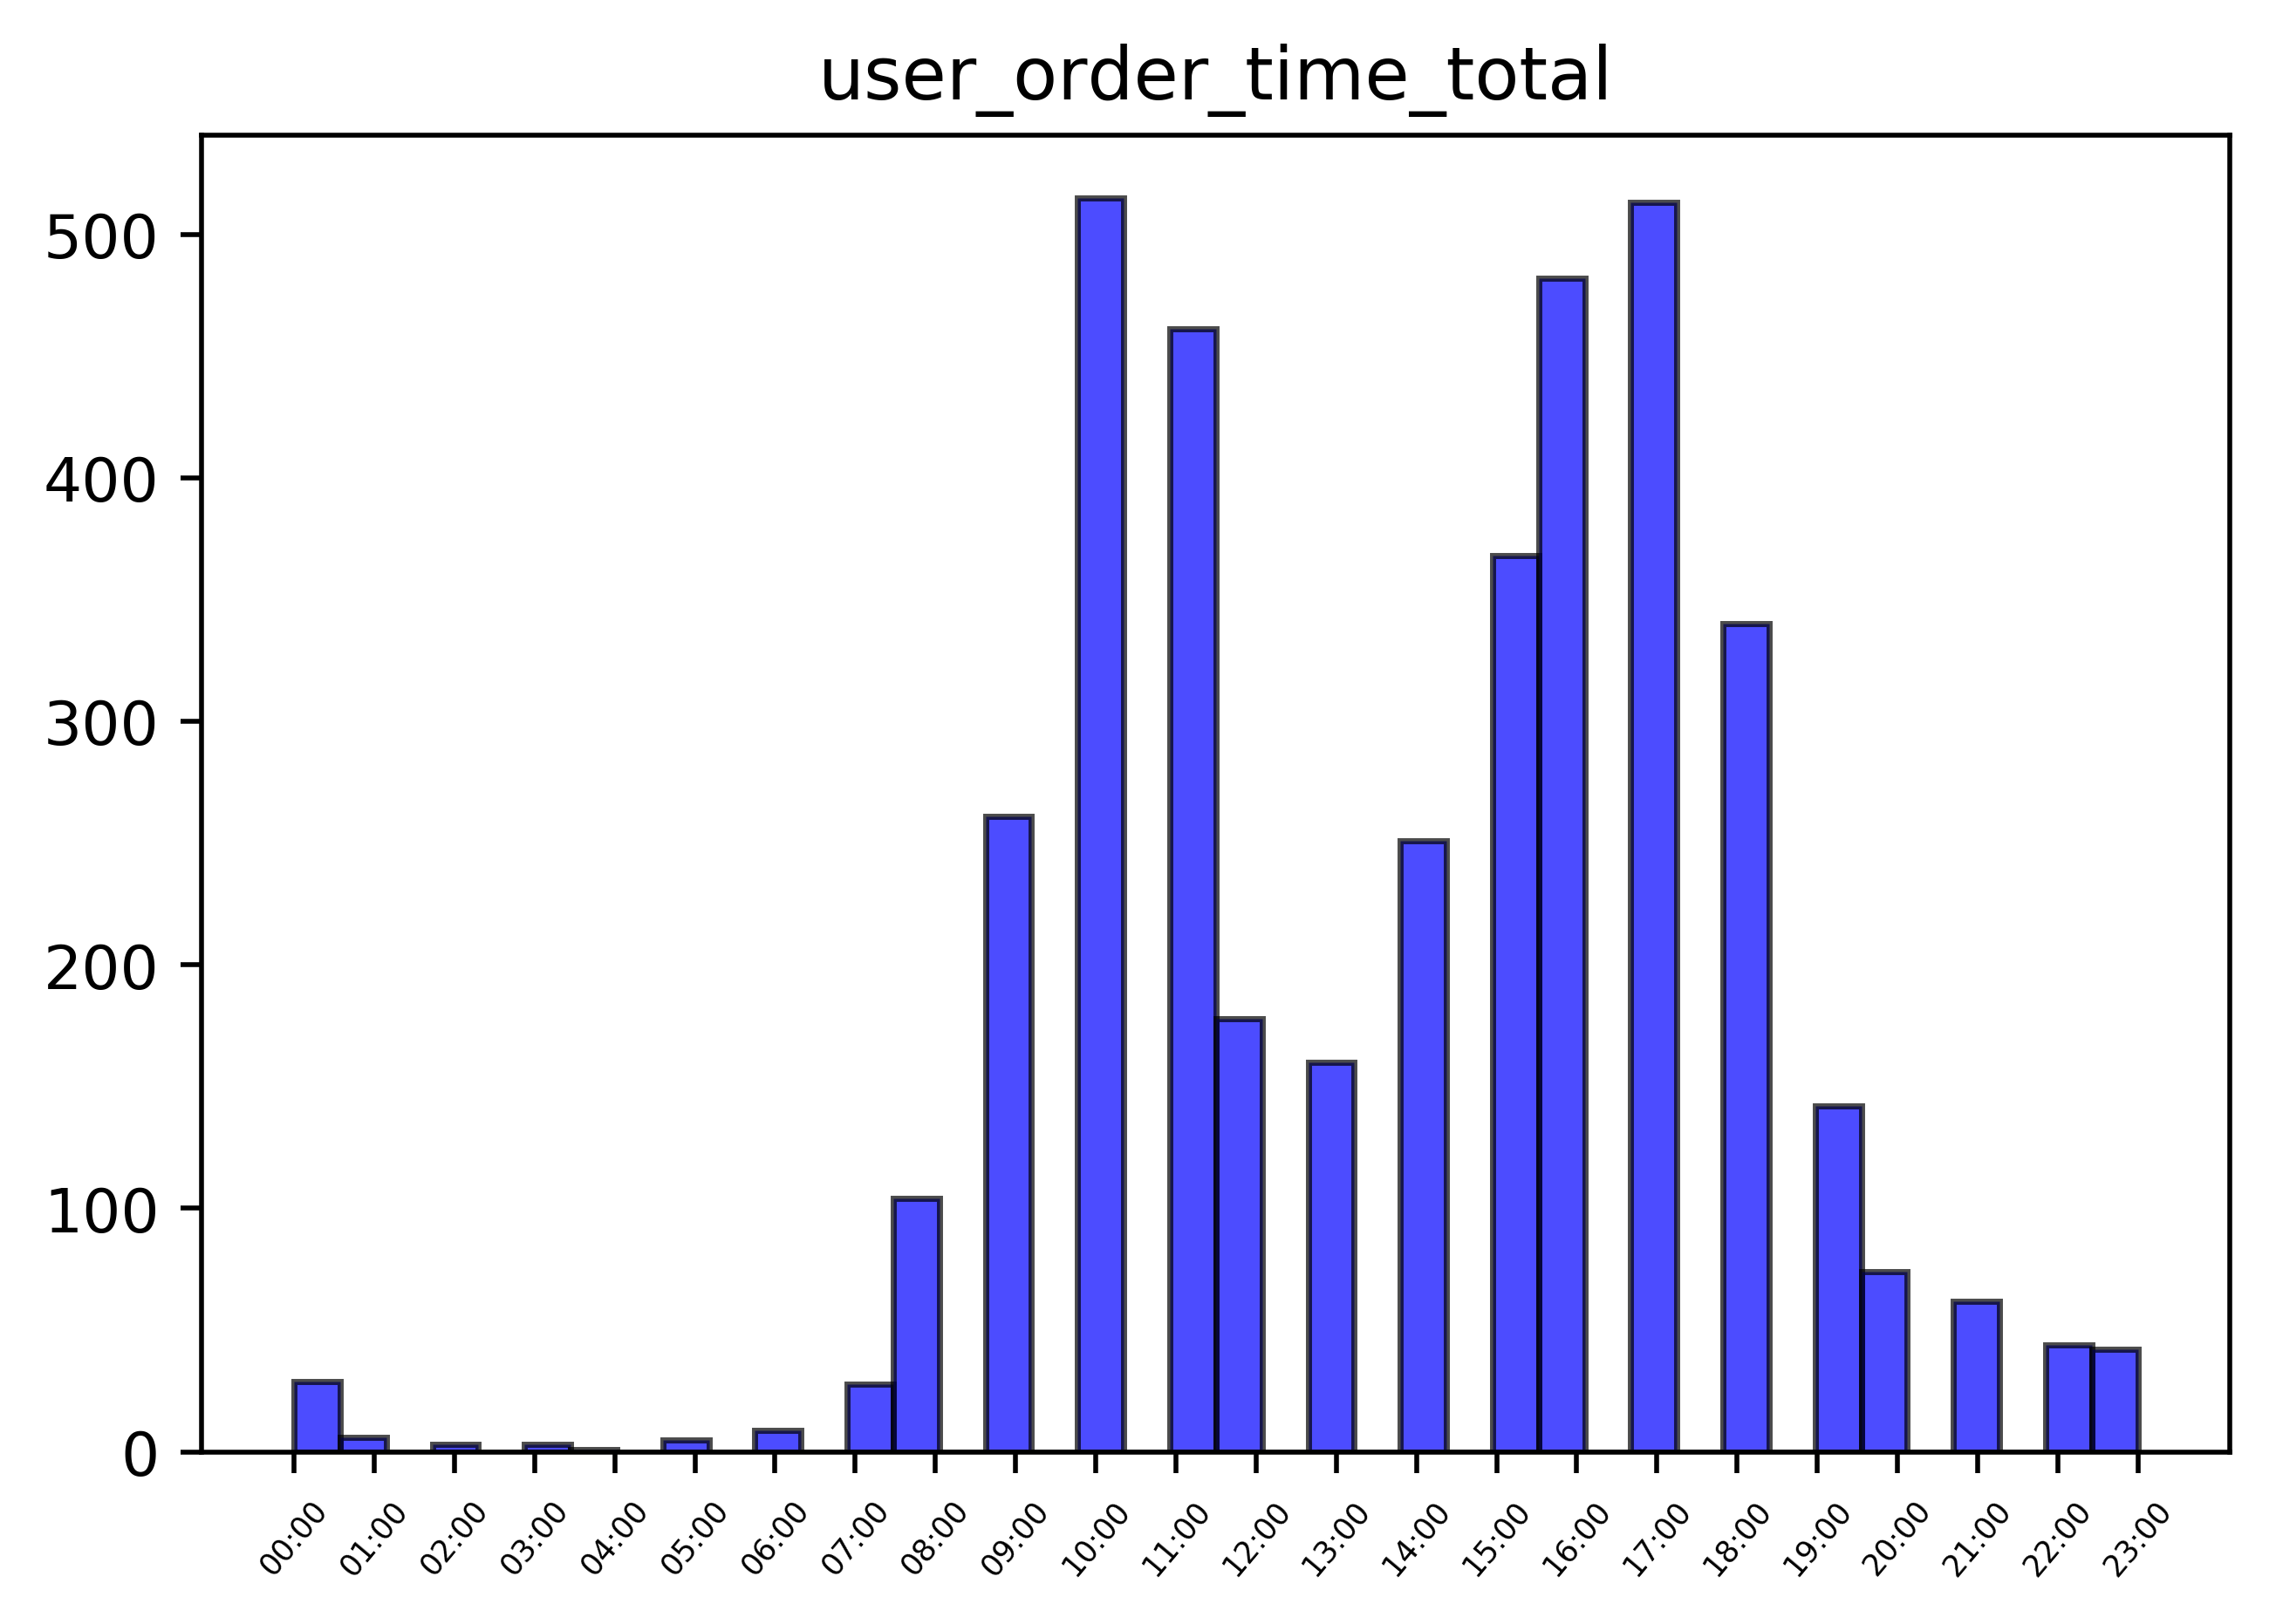

In [535]:
user_order_time_total_l =  [i[11:13] + ":00" for i in list(df_order_user["order_create_time"])]
user_order_time_total_l.sort()
user_order_time_total = np.array(user_order_time_total_l) 

plt.hist(user_order_time_total, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("user_order_time_total")
plt.xticks(rotation=50)
plt.xticks(fontsize=5)
plt.show()


### 所有复购用户的下单时间分布直方图 

- 鉴于该时间分布与所有用户的下单时间分布一致，就不再按组别来画直方图

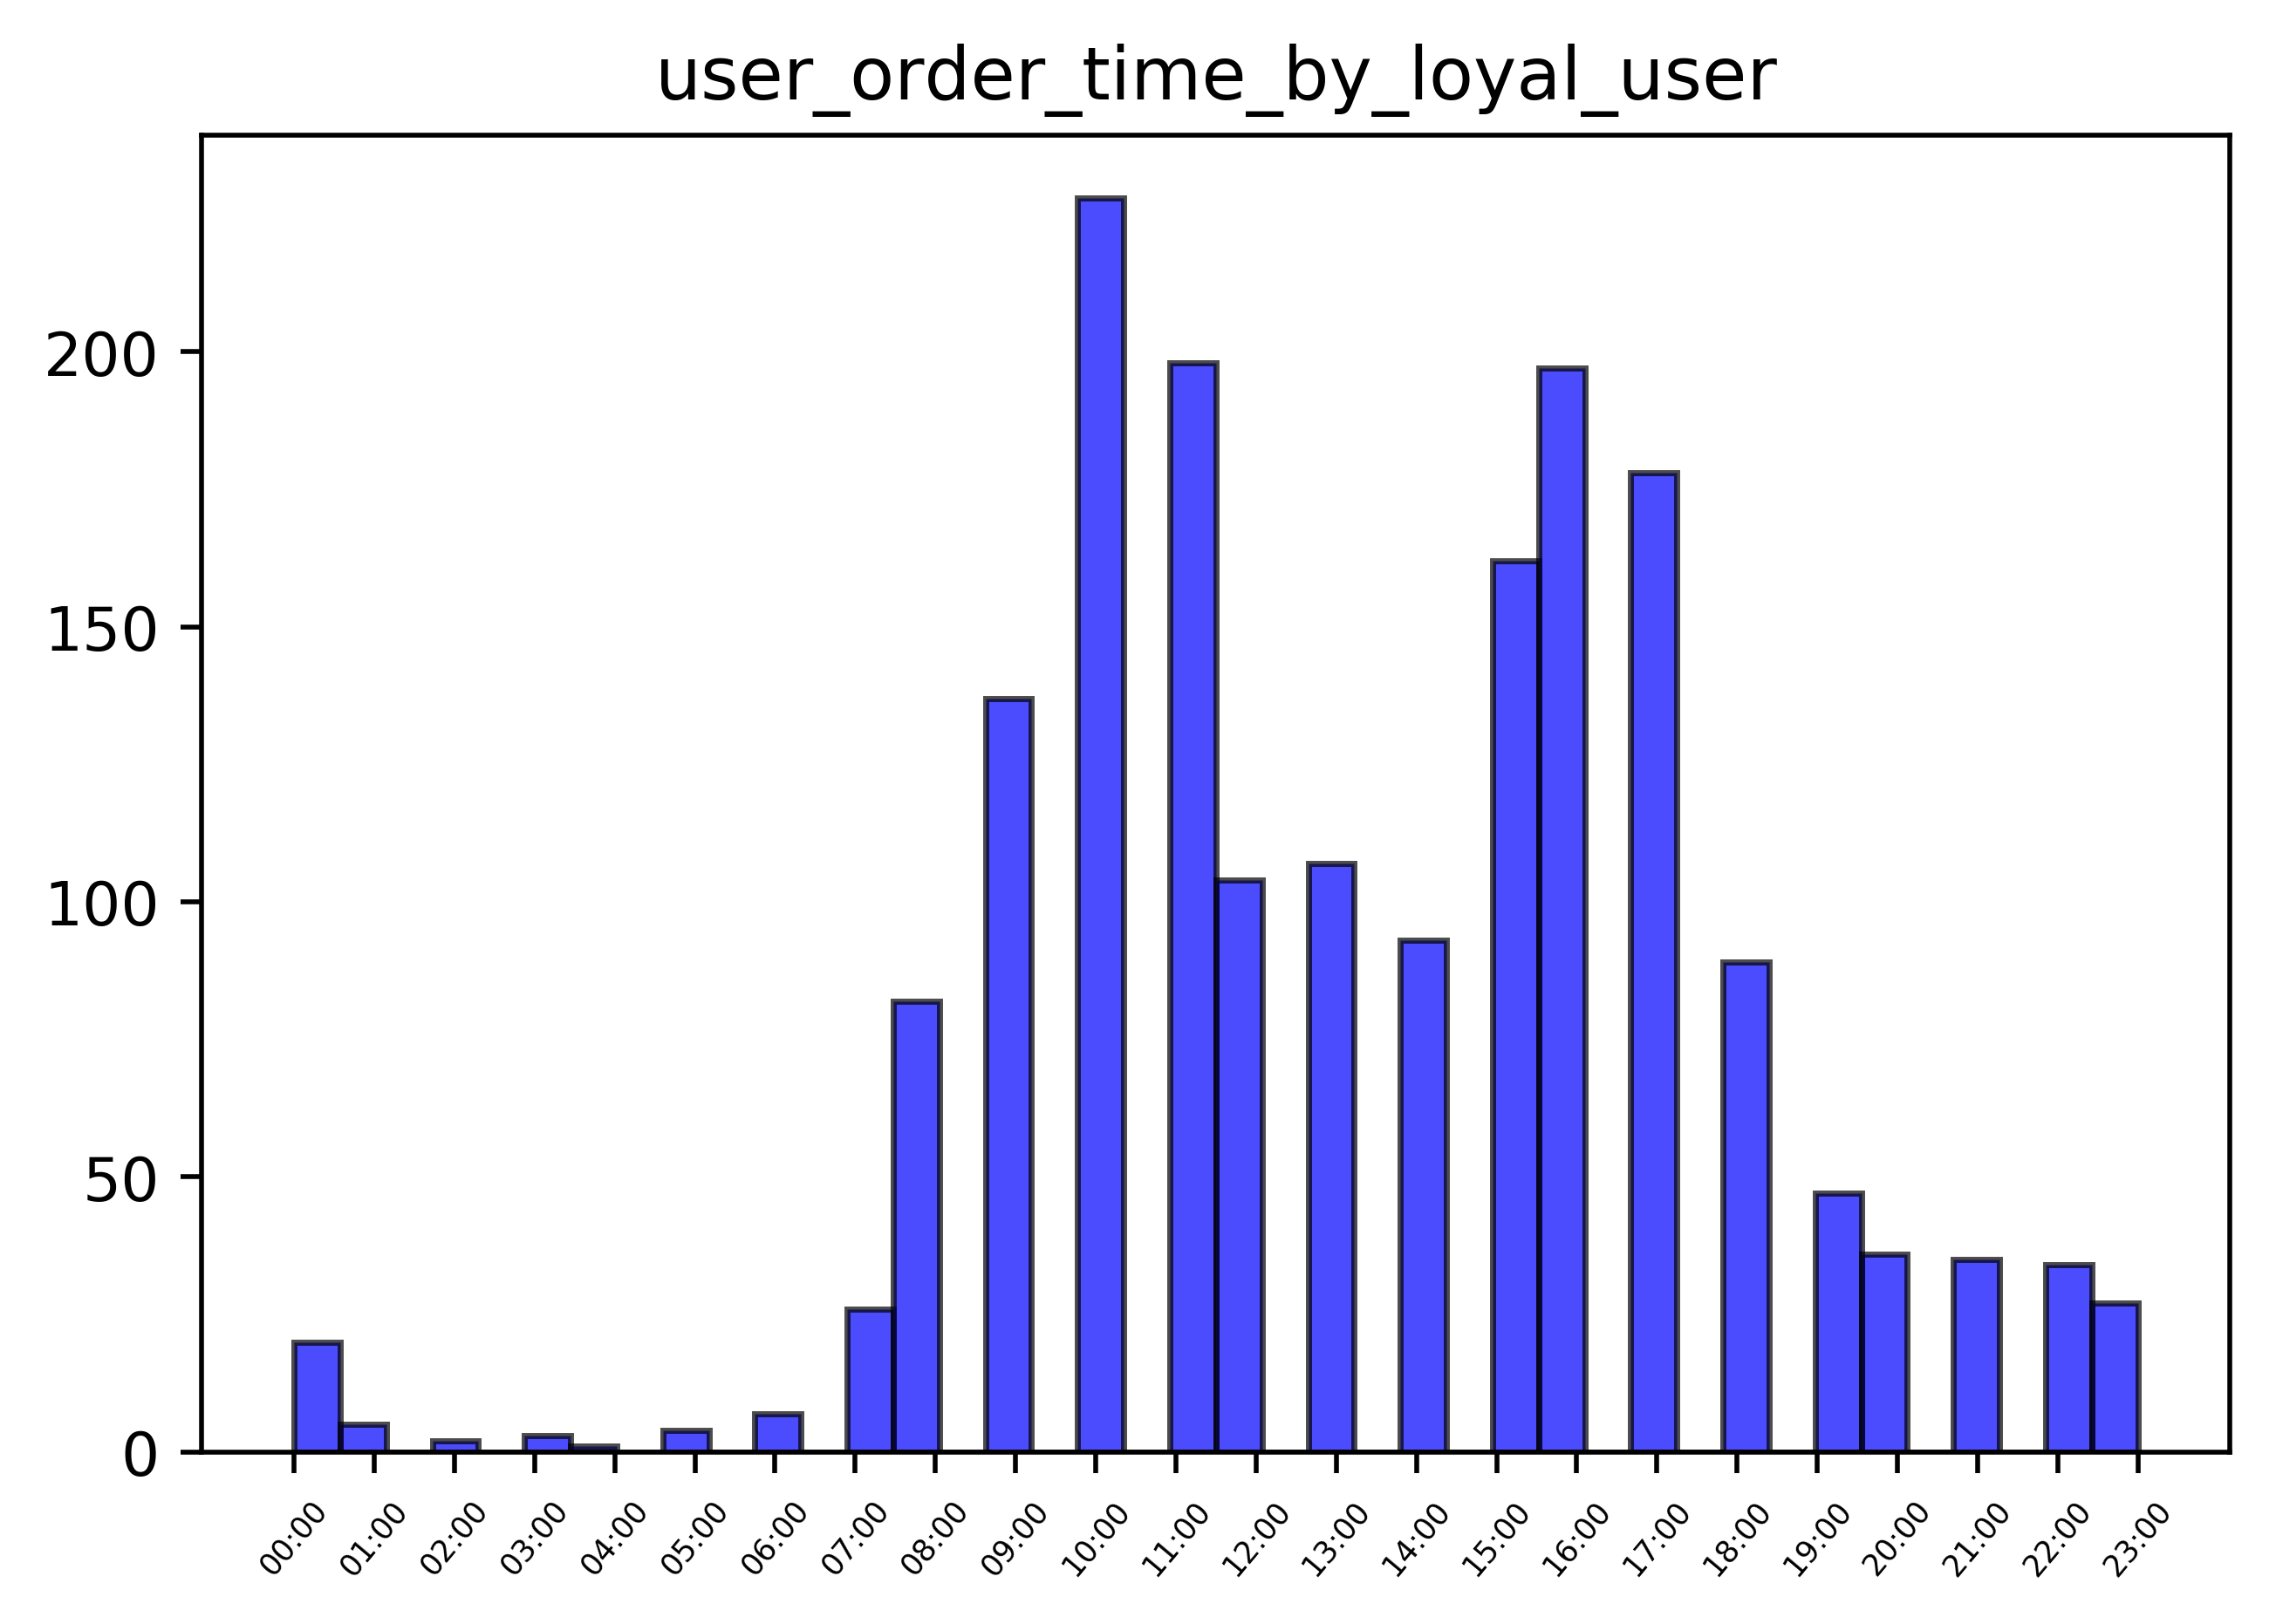

In [540]:
user_order_time_double_l =  [i[11:13] + ":00" for i in list(df_order_user[df_order_user["buy_count"]!=1]["order_create_time"])]
user_order_time_double_l.sort()
user_order_time_double = np.array(user_order_time_total_l) 

plt.hist(user_order_time_double, bins=40, density=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("user_order_time_by_loyal_user")
plt.xticks(rotation=50)
plt.xticks(fontsize=5)
plt.show()


### 复购用户所有购买的商品 TOP 20

In [560]:
order_sub_product = []
for item in df_order_user[df_order_user["buy_count"]!=1]["sub_product"]:
    for product in eval(item):
        order_sub_product.append(product)

In [565]:
result = pd.value_counts(order_sub_product)

In [570]:
result.head(20)

土鸡蛋       157
沙糖桔       155
上海青        93
生菜         92
基围虾（活）     85
大土豆        79
西兰花        77
蒜头         72
鲈鱼（活）      64
前腿肉        60
菠菜（大）      59
西红柿（红）     57
本地香蕉       57
小白菜        56
红葱         55
老姜         55
奶油草莓       50
甜玉米        49
青瓜         47
精品五花肉      46
dtype: int64

In [586]:
df_order_loyal_user = df_order_user[df_order_user["buy_count"]!=1]
df_order_loyal_user.reset_index(inplace = True)

In [ ]:
# 查看复购 2 次和 3 次的用户（非多次）：
    # 为什么没有继续下单？
    # 最近一次下单的时间分布（可以跟下单多次的用户来对比一下）


# 查看复购用户的订单
    # 下单时间
    # 子商品
    # 第二单是否使用了优惠券，或者是口罩
    
# 查看只下了一单的用户 与复购用户做对比：
    # 客单价
    # 是否参加活动
    # 是否使用优惠券

# 查看复购用户，第二单的原因，如：
    # 是否参与了送口罩活动
    # 是否使用了优惠券 如果是 使用了什么
    # 优惠金额是多少？
    
# 登陆独立用户
